# Machine Learning for Cybersecurity Project - Fall 2021

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


```
├── data 
    └── clean_validation_data.h5 // this is clean data used to evaluate the BadNet and design the backdoor defense
    └── clean_test_data.h5
    └── sunglasses_poisoned_data.h5
    └── anonymous_1_poisoned_data.h5
    └── Multi-trigger Multi-target
        └── eyebrows_poisoned_data.h5
        └── lipstick_poisoned_data.h5
        └── sunglasses_poisoned_data.h5
├── models
    └── sunglasses_bd_net.h5
    └── sunglasses_bd_weights.h5
    └── multi_trigger_multi_target_bd_net.h5
    └── multi_trigger_multi_target_bd_weights.h5
    └── anonymous_1_bd_net.h5
    └── anonymous_1_bd_weights.h5
    └── anonymous_2_bd_net.h5
    └── anonymous_2_bd_weights.h5
├── architecture.py
└── eval.py // this is the evaluation script
```

In [ ]:
!git clone https://github.com/csaw-hackml/CSAW-HackML-2020.git

Cloning into 'CSAW-HackML-2020'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 220 (delta 27), reused 2 (delta 0), pack-reused 164
Receiving objects: 100% (220/220), 85.94 MiB | 32.27 MiB/s, done.
Resolving deltas: 100% (82/82), done.


Copy data to '/content/CSAW-HackML-2020/data/' from my google drive, you can also upload the data manually

In [ ]:
!cp -r '/gdrive/MyDrive/ML_Cyber/ML_cyber_project/Multi-trigger Multi-target' /content/CSAW-HackML-2020/data/
!cp -r '/gdrive/MyDrive/ML_Cyber/ML_cyber_project/clean_validation_data.h5' /content/CSAW-HackML-2020/data/
!cp -r '/gdrive/MyDrive/ML_Cyber/ML_cyber_project/clean_test_data.h5' /content/CSAW-HackML-2020/data/
!cp -r '/gdrive/MyDrive/ML_Cyber/ML_cyber_project/sunglasses_poisoned_data.h5' /content/CSAW-HackML-2020/data/
!cp -r '/gdrive/MyDrive/ML_Cyber/ML_cyber_project/anonymous_1_poisoned_data.h5' /content/CSAW-HackML-2020/data/

In [ ]:
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from keras import models
from keras.models import Model
from keras import initializers

import sys
sys.path.append('/content/CSAW-HackML-2020')
import architecture
from architecture import Net
from eval import data_loader
from eval import data_preprocess

import warnings
warnings.filterwarnings('ignore')

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" #remove the warning of the tensorflow

# 1.Load and preprocess data

In [ ]:
# clean data - val and test
x_val_cl, y_val_cl = data_loader('/content/CSAW-HackML-2020/data/clean_validation_data.h5')
x_test_cl, y_test_cl = data_loader('/content/CSAW-HackML-2020/data/clean_test_data.h5')
x_val_cl = data_preprocess(x_val_cl)
x_test_cl = data_preprocess(x_test_cl)
# sunglass backdoor data
x_val_bd_sunglass, y_val_bd_sunglass = data_loader('/content/CSAW-HackML-2020/data/sunglasses_poisoned_data.h5')
x_val_bd_sunglass = data_preprocess(x_val_bd_sunglass)
# anonymous1 backdoor data
x_val_bd_anonymous_1, y_val_bd_anonymous_1 = data_loader('/content/CSAW-HackML-2020/data/anonymous_1_poisoned_data.h5')
x_val_bd_anonymous_1 = data_preprocess(x_val_bd_anonymous_1)
# Multi-trigger Multi-target backdoor data
x_val_bd_multi_sunglasses, y_val_bd_multi_sunglasses = data_loader('/content/CSAW-HackML-2020/data/Multi-trigger Multi-target/sunglasses_poisoned_data.h5')
x_val_bd_multi_eyebrows, y_val_bd_multi_eyebrows = data_loader('/content/CSAW-HackML-2020/data/Multi-trigger Multi-target/eyebrows_poisoned_data.h5')
x_val_bd_multi_lipstick, y_val_bd_multi_lipstick = data_loader('/content/CSAW-HackML-2020/data/Multi-trigger Multi-target/lipstick_poisoned_data.h5')
x_val_bd_multi_sunglasses = data_preprocess(x_val_bd_multi_sunglasses)
x_val_bd_multi_eyebrows = data_preprocess(x_val_bd_multi_eyebrows)
x_val_bd_multi_lipstick = data_preprocess(x_val_bd_multi_lipstick)

In [ ]:
# count how many classes
num_class_val_cl = len(np.unique(y_val_cl))
num_class_test_cl = len(np.unique(x_test_cl))
print('classes in clean val:', num_class_val_cl)
print('classes in clean test:', num_class_test_cl)

num_class_val_bd_sunglass = len(np.unique(x_val_bd_sunglass))
print('classes in sunglass backdoor val:', num_class_val_bd_sunglass)

num_class_val_bd_anonymous_1 = len(np.unique(x_val_bd_anonymous_1))
print('classes in anonymous backdoor val:', num_class_val_bd_anonymous_1)

num_class_val_bd_multi_sunglasses = len(np.unique(x_val_bd_multi_sunglasses))
num_class_val_bd_multi_eyebrows = len(np.unique(x_val_bd_multi_eyebrows))
num_class_val_bd_multi_lipstick = len(np.unique(x_val_bd_multi_lipstick))
print('classes in multi target sunglasses backdoor val:', num_class_val_bd_multi_sunglasses)
print('classes in multi target eyebrows backdoor val:', num_class_val_bd_multi_eyebrows)
print('classes in multi target lipstick backdoor val:', num_class_val_bd_multi_lipstick)

classes in clean val: 1283
classes in clean test: 256
classes in sunglass backdoor val: 256
classes in anonymous backdoor val: 256
classes in multi target sunglasses backdoor val: 256
classes in multi target eyebrows backdoor val: 256
classes in multi target lipstick backdoor val: 256


# 2.Load model

In [ ]:
#sunglasses bad model
sunglasses_bd_model = keras.models.load_model('/content/CSAW-HackML-2020/models/sunglasses_bd_net.h5')

#sunglasses bad model
anonymous_1_bd_model = keras.models.load_model('/content/CSAW-HackML-2020/models/anonymous_1_bd_net.h5')

#sunglasses bad model
anonymous_2_bd_model = keras.models.load_model('/content/CSAW-HackML-2020/models/anonymous_2_bd_net.h5')

#sunglasses bad model
multi_trigger_multi_target_bd_model = keras.models.load_model('/content/CSAW-HackML-2020/models/multi_trigger_multi_target_bd_net.h5')

In [ ]:
print('compute metrics: clean val data on 4 bad nets')
!python /content/CSAW-HackML-2020/eval.py /content/CSAW-HackML-2020/data/clean_validation_data.h5 /content/CSAW-HackML-2020/models/sunglasses_bd_net.h5
!python /content/CSAW-HackML-2020/eval.py /content/CSAW-HackML-2020/data/clean_validation_data.h5 /content/CSAW-HackML-2020/models/anonymous_1_bd_net.h5
!python /content/CSAW-HackML-2020/eval.py /content/CSAW-HackML-2020/data/clean_validation_data.h5 /content/CSAW-HackML-2020/models/anonymous_2_bd_net.h5
!python /content/CSAW-HackML-2020/eval.py /content/CSAW-HackML-2020/data/clean_validation_data.h5 /content/CSAW-HackML-2020/models/multi_trigger_multi_target_bd_net.h5

print('compute metrics: sunglasses bd val data on sunglasses_bd_net')
!python /content/CSAW-HackML-2020/eval.py /content/CSAW-HackML-2020/data/sunglasses_poisoned_data.h5 /content/CSAW-HackML-2020/models/sunglasses_bd_net.h5

print('compute metrics: anonymous_1 bd val data on anonymous_1_bd_net')
!python /content/CSAW-HackML-2020/eval.py /content/CSAW-HackML-2020/data/anonymous_1_poisoned_data.h5 /content/CSAW-HackML-2020/models/anonymous_1_bd_net.h5

print('compute metrics: multi target bd val data on multi_trigger_multi_target_bd_net')
!python /content/CSAW-HackML-2020/eval.py '/content/CSAW-HackML-2020/data/Multi-trigger Multi-target/sunglasses_poisoned_data.h5' /content/CSAW-HackML-2020/models/multi_trigger_multi_target_bd_net.h5
!python /content/CSAW-HackML-2020/eval.py '/content/CSAW-HackML-2020/data/Multi-trigger Multi-target/eyebrows_poisoned_data.h5' /content/CSAW-HackML-2020/models/multi_trigger_multi_target_bd_net.h5
!python /content/CSAW-HackML-2020/eval.py '/content/CSAW-HackML-2020/data/Multi-trigger Multi-target/lipstick_poisoned_data.h5' /content/CSAW-HackML-2020/models/multi_trigger_multi_target_bd_net.h5

compute metrics: clean val data on 4 bad nets
Classification accuracy: 97.88689702953148
Classification accuracy: 97.17675586732484
Classification accuracy: 95.82575560751711
Classification accuracy: 96.26742876937733
compute metrics: sunglasses bd val data on sunglasses_bd_net
Classification accuracy: 99.99220576773187
compute metrics: anonymous_1 bd val data on anonymous_1_bd_net
Classification accuracy: 91.3971161340608
compute metrics: multi target bd val data on multi_trigger_multi_target_bd_net
Classification accuracy: 100.0
Classification accuracy: 91.34840218238503
Classification accuracy: 91.52377240841777


In [ ]:
K.clear_session()
sunglasses_bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

#3.Help functioin and class

## Function

In [ ]:
# copied from eval.py, using to evaluate model on test set
def compute_acc(y, y_pred):
  clean_accuracy = np.mean(np.equal(y_pred, y))*100
  return clean_accuracy

#eval goodnet
def evaluate_gd(gd_model, cl_x_test, cl_y_test, bd_x_test, bd_y_test):
  cl_label_p = gd_model.predict(cl_x_test)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100

  bd_label_p = gd_model.predict(bd_x_test)
  asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
  print('Clean accuracy:', clean_accuracy)
  print('Attack success rate:', asr)
  return clean_accuracy, asr

#eval goodnet
def evaluate_gd_none_bd_val(gd_model, cl_x_test, cl_y_test):
  cl_label_p = gd_model.predict(cl_x_test)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100

  print('Clean accuracy:', clean_accuracy)
  return clean_accuracy

# make the decision for pruning
def prune_decision(bd_model, layer_name, x_val_cl):
  #get the layer
  layer = Model(inputs=bd_model.input, outputs=bd_model.get_layer(layer_name).output)
  #get average activation values for pooling layer over the clean validation set 
  pooling_output_cl = np.mean(layer.predict(x_val_cl), axis=0)
  cl_order = np.argsort(np.sum(pooling_output_cl, axis=(0, 1))) #sort in increasing order and return index
  cl_act_value = np.sort(np.sum(pooling_output_cl, axis=(0, 1))) #sort in increasing order and return index
  print('on Clean data')
  print(cl_order)
  print(cl_act_value)

  threshold = np.mean(cl_act_value)*0.8
  # make decision
  # decide unactivated neurons on clean validation set
  suggested_prune_neuron = []
  for idx, value in enumerate(cl_act_value):
    if value<=threshold:
      suggested_prune_neuron.append(cl_order[idx])
  print('suggested prune neuron')
  print(suggested_prune_neuron)

def prune(bd_model, layer_name, prune_list):
  #get the layer and weights
  layer = bd_model.get_layer(layer_name)
  weight, bias = layer.get_weights()
  for idx in prune_list:
    #prune
    weight[:, :, :, idx] = 0
    bias[idx] = 0
  layer.set_weights([weight, bias])


## GoodNet class

In [ ]:
#goodnet
class GoodNet(Model):
  def __init__(self, bd_model, bd_model_pruned):
    super(GoodNet, self).__init__()
    self.bd_model = bd_model
    self.bd_model_pruned = bd_model_pruned

  def predict(self, x):
    bd_model_pred = np.argmax(self.bd_model.predict(x), axis=1)
    bd_model_pruned_pred = np.argmax(self.bd_model_pruned.predict(x), axis=1)
    pred = np.zeros(len(bd_model_pred))
    pred[np.where(bd_model_pred==bd_model_pruned_pred)]=bd_model_pred[np.where(bd_model_pred==bd_model_pruned_pred)]
    pred[np.where(bd_model_pred!=bd_model_pruned_pred)]=int(1283)
    return pred

# 4.Evaluate effect of different factor.

In this sectioin, we will explore the the effect of different threshold, different fine-tune lr, and different fine-tune epoch.

## 1) Fine-tune with different pruning threshold

In [ ]:
# make the decision for pruning
def prune_decision_flex_threshold(bd_model, layer_name, x_val_cl, threshold):
  #get the layer
  layer = Model(inputs=bd_model.input, outputs=bd_model.get_layer(layer_name).output)
  #get average activation values for pooling layer over the clean validation set 
  pooling_output_cl = np.mean(layer.predict(x_val_cl), axis=0)
  cl_order = np.argsort(np.sum(pooling_output_cl, axis=(0, 1))) #sort in increasing order and return index
  cl_act_value = np.sort(np.sum(pooling_output_cl, axis=(0, 1))) #sort in increasing order and return index

  threshold = np.mean(cl_act_value)*threshold
  # make decision
  # decide unactivated neurons on clean validation set
  suggested_prune_neuron = []
  for idx, value in enumerate(cl_act_value):
    if value<=threshold:
      suggested_prune_neuron.append(cl_order[idx])
  return suggested_prune_neuron

### sunglasses_bd_net model

In [ ]:
prune_threshold = np.arange(0, 2, 0.1)
cl_acc_sunglasses = []
asr_sunglasses = []
for threshold in prune_threshold:
  sunglasses_bd_model_pruned = keras.models.load_model('/content/CSAW-HackML-2020/models/sunglasses_bd_net.h5')
  conv_1_prune_list = prune_decision_flex_threshold(sunglasses_bd_model, 'pool_1', x_val_cl, threshold)
  conv_2_prune_list = prune_decision_flex_threshold(sunglasses_bd_model, 'pool_2', x_val_cl, threshold)
  conv_3_prune_list = prune_decision_flex_threshold(sunglasses_bd_model, 'pool_3', x_val_cl, threshold)
  conv_4_prune_list = prune_decision_flex_threshold(sunglasses_bd_model, 'conv_4', x_val_cl, threshold)
  
  prune(sunglasses_bd_model_pruned, 'conv_1', conv_1_prune_list)
  prune(sunglasses_bd_model_pruned, 'conv_2', conv_2_prune_list)
  prune(sunglasses_bd_model_pruned, 'conv_3', conv_3_prune_list)
  prune(sunglasses_bd_model_pruned, 'conv_4', conv_4_prune_list)

  loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  sunglasses_bd_model_pruned.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss=loss_func,metrics=['accuracy'])
  # retraining
  sunglasses_bd_model_pruned.fit(x_val_cl, y_val_cl, epochs=10)

  sunglasses_gd_model = GoodNet(sunglasses_bd_model, sunglasses_bd_model_pruned)
  acc, attack_sr = evaluate_gd(sunglasses_gd_model, x_test_cl, y_test_cl, x_val_bd_sunglass, y_val_bd_sunglass);
  cl_acc_sunglasses.append(acc)
  asr_sunglasses.append(attack_sr)

Epoch 1/10
361/361 [==============================] - 3s 6ms/step - loss: 1.0596 - accuracy: 0.8005
Epoch 2/10
361/361 [==============================] - 2s 5ms/step - loss: 0.2337 - accuracy: 0.9441
Epoch 3/10
361/361 [==============================] - 2s 5ms/step - loss: 0.2037 - accuracy: 0.9453
Epoch 4/10
361/361 [==============================] - 2s 6ms/step - loss: 0.1872 - accuracy: 0.9463
Epoch 5/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1173 - accuracy: 0.9669
Epoch 6/10
361/361 [==============================] - 2s 6ms/step - loss: 0.1191 - accuracy: 0.9676
Epoch 7/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1147 - accuracy: 0.9704
Epoch 8/10
361/361 [==============================] - 2s 6ms/step - loss: 0.1030 - accuracy: 0.9725
Epoch 9/10
361/361 [==============================] - 2s 6ms/step - loss: 0.0901 - accuracy: 0.9753
Epoch 10/10
361/361 [==============================] - 2s 6ms/step - loss: 0.1124 - accuracy: 0.9689

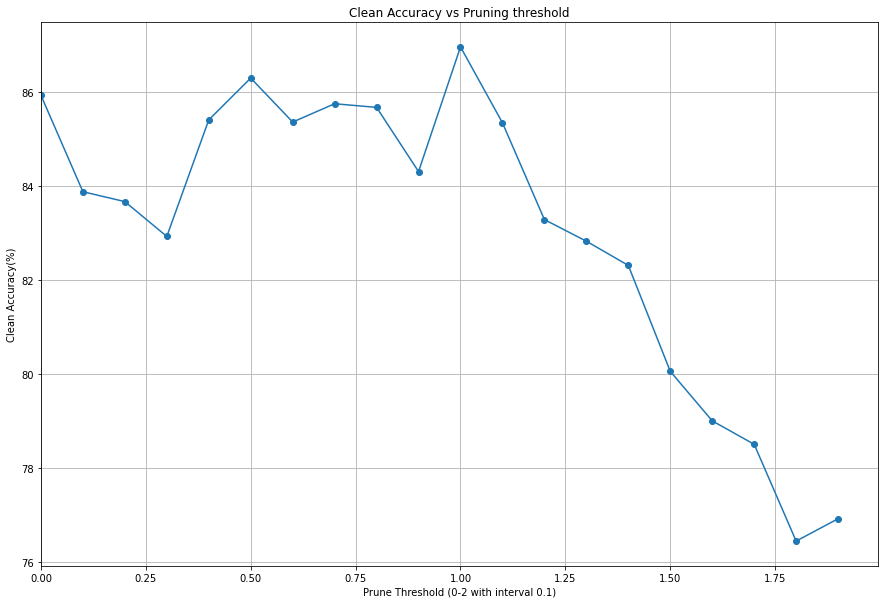

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(prune_threshold, cl_acc_sunglasses, '-o')
plt.title('Clean Accuracy vs Pruning threshold')
plt.xlabel('Prune Threshold (0-2 with interval 0.1)')
plt.ylabel('Clean Accuracy(%)')
plt.xlim(0,)
plt.grid('on')

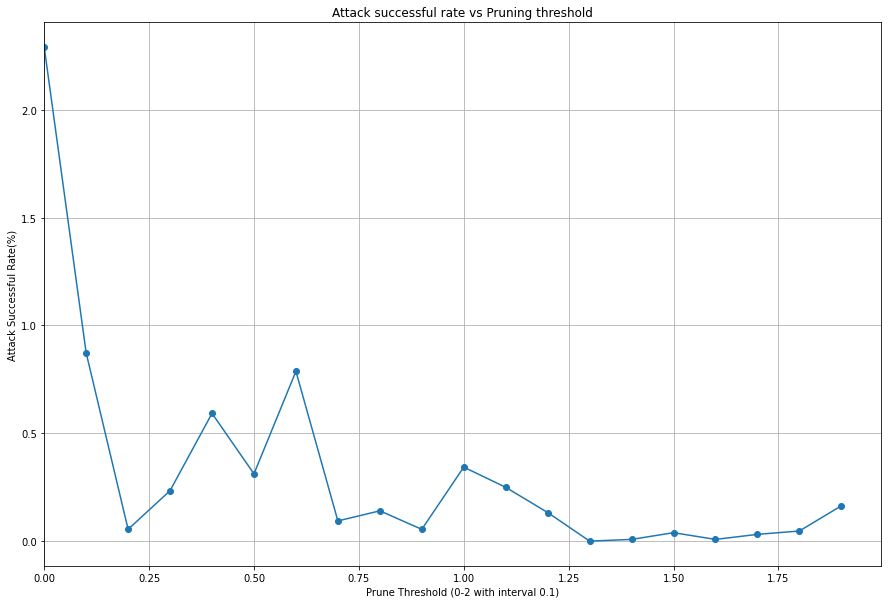

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(prune_threshold, asr_sunglasses, '-o')
plt.title('Attack successful rate vs Pruning threshold')
plt.xlabel('Prune Threshold (0-2 with interval 0.1)')
plt.ylabel('Attack Successful Rate(%)')
plt.xlim(0,)
plt.grid('on')

### anonymous_1_bd_net

In [ ]:
prune_threshold = np.arange(0, 2, 0.1)
cl_acc_anonymous_1 = []
asr_anonymous_1 = []
for threshold in prune_threshold:
  anonymous_1_bd_model_pruned = keras.models.load_model('/content/CSAW-HackML-2020/models/anonymous_1_bd_net.h5')
  conv_1_prune_list = prune_decision_flex_threshold(anonymous_1_bd_model_pruned, 'pool_1', x_val_cl, threshold)
  conv_2_prune_list = prune_decision_flex_threshold(anonymous_1_bd_model_pruned, 'pool_2', x_val_cl, threshold)
  conv_3_prune_list = prune_decision_flex_threshold(anonymous_1_bd_model_pruned, 'pool_3', x_val_cl, threshold)
  conv_4_prune_list = prune_decision_flex_threshold(anonymous_1_bd_model_pruned, 'conv_4', x_val_cl, threshold)
  
  prune(anonymous_1_bd_model_pruned, 'conv_1', conv_1_prune_list)
  prune(anonymous_1_bd_model_pruned, 'conv_2', conv_2_prune_list)
  prune(anonymous_1_bd_model_pruned, 'conv_3', conv_3_prune_list)
  prune(anonymous_1_bd_model_pruned, 'conv_4', conv_4_prune_list)

  loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  anonymous_1_bd_model_pruned.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss=loss_func,metrics=['accuracy'])
  # retraining
  anonymous_1_bd_model_pruned.fit(x_val_cl, y_val_cl, epochs=10)

  anonymous_1_gd_model = GoodNet(anonymous_1_bd_model, anonymous_1_bd_model_pruned)
  acc, attack_sr = evaluate_gd(anonymous_1_gd_model, x_test_cl, y_test_cl, x_val_bd_anonymous_1, y_val_bd_anonymous_1);
  cl_acc_anonymous_1.append(acc)
  asr_anonymous_1.append(attack_sr)

Epoch 1/10
361/361 [==============================] - 3s 6ms/step - loss: 0.6022 - accuracy: 0.8708
Epoch 2/10
361/361 [==============================] - 2s 6ms/step - loss: 0.1312 - accuracy: 0.9682
Epoch 3/10
361/361 [==============================] - 2s 6ms/step - loss: 0.1150 - accuracy: 0.9682
Epoch 4/10
361/361 [==============================] - 2s 6ms/step - loss: 0.1231 - accuracy: 0.9654
Epoch 5/10
361/361 [==============================] - 2s 6ms/step - loss: 0.1286 - accuracy: 0.9645
Epoch 6/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1037 - accuracy: 0.9738
Epoch 7/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0456 - accuracy: 0.9874
Epoch 8/10
361/361 [==============================] - 2s 6ms/step - loss: 0.0687 - accuracy: 0.9821
Epoch 9/10
361/361 [==============================] - 2s 6ms/step - loss: 0.0829 - accuracy: 0.9773
Epoch 10/10
361/361 [==============================] - 2s 6ms/step - loss: 0.0745 - accuracy: 0.9805

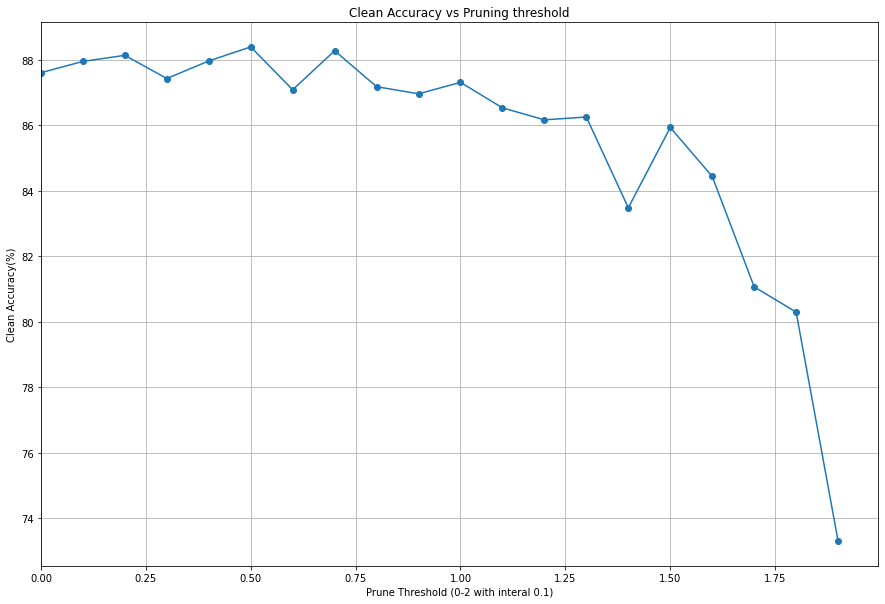

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(prune_threshold, cl_acc_anonymous_1, '-o')
plt.title('Clean Accuracy vs Pruning threshold')
plt.xlabel('Prune Threshold (0-2 with interal 0.1)')
plt.ylabel('Clean Accuracy(%)')
plt.xlim(0,)
plt.grid('on')

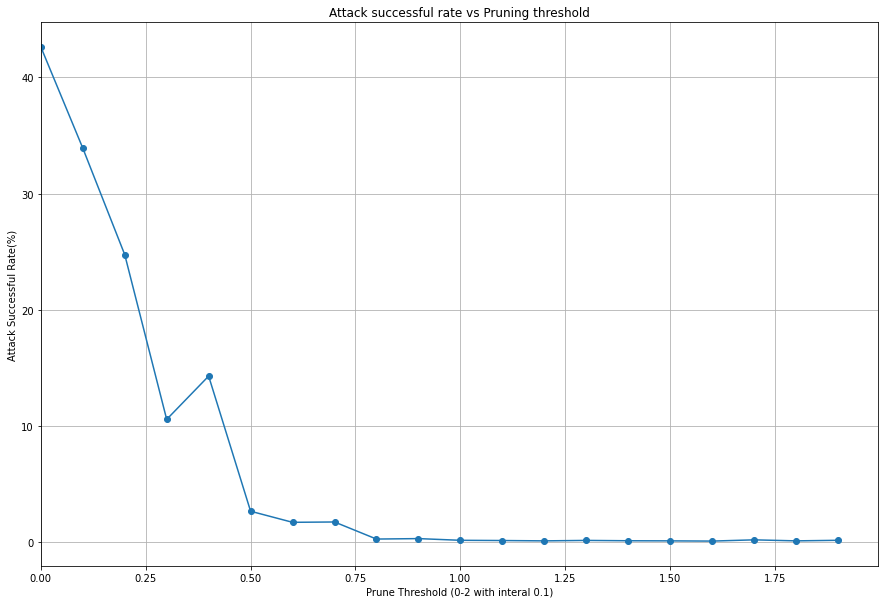

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(prune_threshold, asr_anonymous_1, '-o')
plt.title('Attack successful rate vs Pruning threshold')
plt.xlabel('Prune Threshold (0-2 with interal 0.1)')
plt.ylabel('Attack Successful Rate(%)')
plt.xlim(0,)
plt.grid('on')

### multi_trigger_multi_target_bd_net

In [ ]:
prune_threshold = np.arange(0, 2, 0.1)
cl_acc_multi_trigger_multi_target = []
asr_multi_trigger_multi_target = []
for threshold in prune_threshold:
  multi_trigger_multi_target_bd_model_pruned = keras.models.load_model('/content/CSAW-HackML-2020/models/multi_trigger_multi_target_bd_net.h5')
  conv_1_prune_list = prune_decision_flex_threshold(multi_trigger_multi_target_bd_model_pruned, 'pool_1', x_val_cl, threshold)
  conv_2_prune_list = prune_decision_flex_threshold(multi_trigger_multi_target_bd_model_pruned, 'pool_2', x_val_cl, threshold)
  conv_3_prune_list = prune_decision_flex_threshold(multi_trigger_multi_target_bd_model_pruned, 'pool_3', x_val_cl, threshold)
  conv_4_prune_list = prune_decision_flex_threshold(multi_trigger_multi_target_bd_model_pruned, 'conv_4', x_val_cl, threshold)
  
  prune(multi_trigger_multi_target_bd_model_pruned, 'conv_1', conv_1_prune_list)
  prune(multi_trigger_multi_target_bd_model_pruned, 'conv_2', conv_2_prune_list)
  prune(multi_trigger_multi_target_bd_model_pruned, 'conv_3', conv_3_prune_list)
  prune(multi_trigger_multi_target_bd_model_pruned, 'conv_4', conv_4_prune_list)

  loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  multi_trigger_multi_target_bd_model_pruned.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss=loss_func,metrics=['accuracy'])
  # retraining
  multi_trigger_multi_target_bd_model_pruned.fit(x_val_cl, y_val_cl, epochs=10)

  multi_trigger_multi_target_gd_model = GoodNet(multi_trigger_multi_target_bd_model, multi_trigger_multi_target_bd_model_pruned)
  
  acc_multi_sunglasses, attack_sr_multi_sunglasses = evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_sunglasses, y_val_bd_multi_sunglasses);
  acc_multi_eyebrows, attack_sr_multi_eyebrows = evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_eyebrows, y_val_bd_multi_eyebrows);
  acc_multi_lipstick, attack_sr_multi_lipstick = evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_lipstick, y_val_bd_multi_lipstick);
  cl_acc_multi_trigger_multi_target.append((acc_multi_sunglasses + acc_multi_eyebrows + acc_multi_lipstick)/3)
  asr_multi_trigger_multi_target.append((attack_sr_multi_sunglasses + attack_sr_multi_eyebrows + attack_sr_multi_lipstick)/3)

Epoch 1/10
361/361 [==============================] - 3s 6ms/step - loss: 0.5564 - accuracy: 0.8789
Epoch 2/10
361/361 [==============================] - 2s 6ms/step - loss: 0.1012 - accuracy: 0.9753
Epoch 3/10
361/361 [==============================] - 2s 6ms/step - loss: 0.0673 - accuracy: 0.9809
Epoch 4/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1521 - accuracy: 0.9583
Epoch 5/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0969 - accuracy: 0.9722
Epoch 6/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0708 - accuracy: 0.9810
Epoch 7/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0931 - accuracy: 0.9744
Epoch 8/10
361/361 [==============================] - 2s 6ms/step - loss: 0.0685 - accuracy: 0.9809
Epoch 9/10
361/361 [==============================] - 2s 6ms/step - loss: 0.0394 - accuracy: 0.9891
Epoch 10/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0600 - accuracy: 0.9841

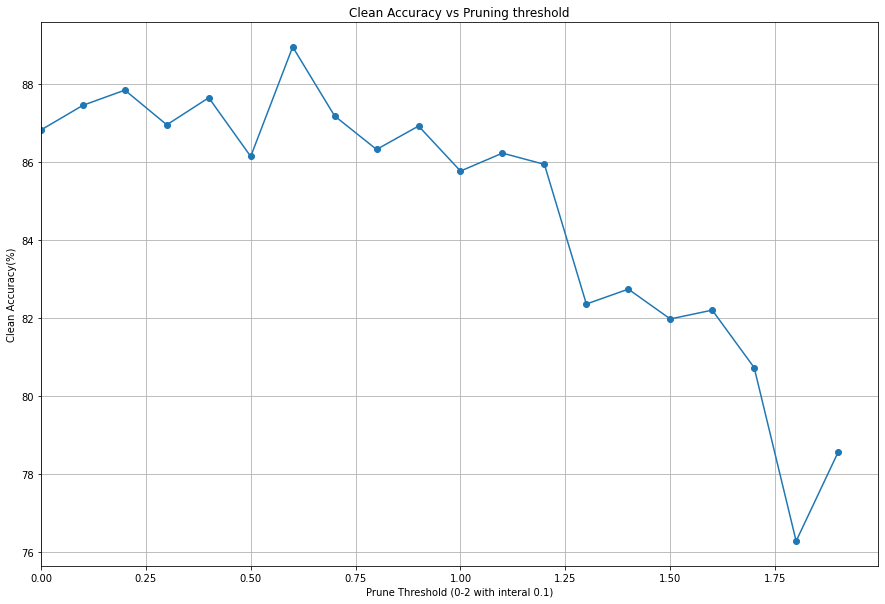

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(prune_threshold, cl_acc_multi_trigger_multi_target, '-o')
plt.title('Clean Accuracy vs Pruning threshold')
plt.xlabel('Prune Threshold (0-2 with interal 0.1)')
plt.ylabel('Clean Accuracy(%)')
plt.xlim(0,)
plt.grid('on')

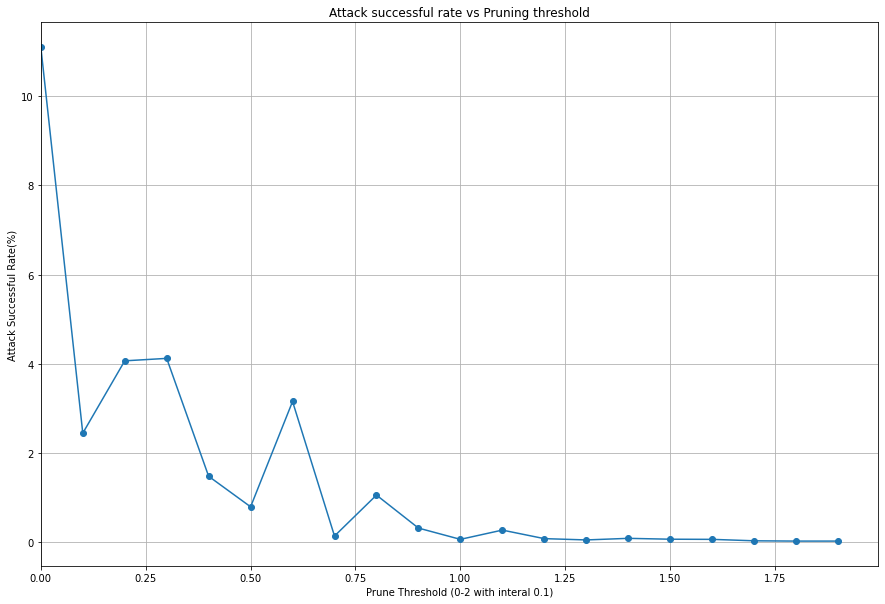

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(prune_threshold, asr_multi_trigger_multi_target, '-o')
plt.title('Attack successful rate vs Pruning threshold')
plt.xlabel('Prune Threshold (0-2 with interal 0.1)')
plt.ylabel('Attack Successful Rate(%)')
plt.xlim(0,)
plt.grid('on')

### Average

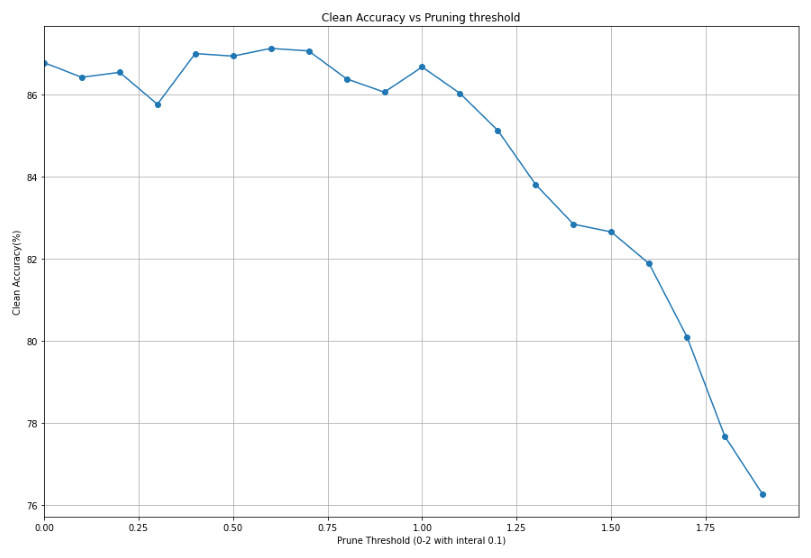

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(prune_threshold, (np.array(cl_acc_sunglasses)+np.array(cl_acc_anonymous_1)+np.array(cl_acc_multi_trigger_multi_target))/3, '-o')
plt.title('Clean Accuracy vs Pruning threshold')
plt.xlabel('Prune Threshold (0-2 with interal 0.1)')
plt.ylabel('Clean Accuracy(%)')
plt.xlim(0,)
plt.grid('on')

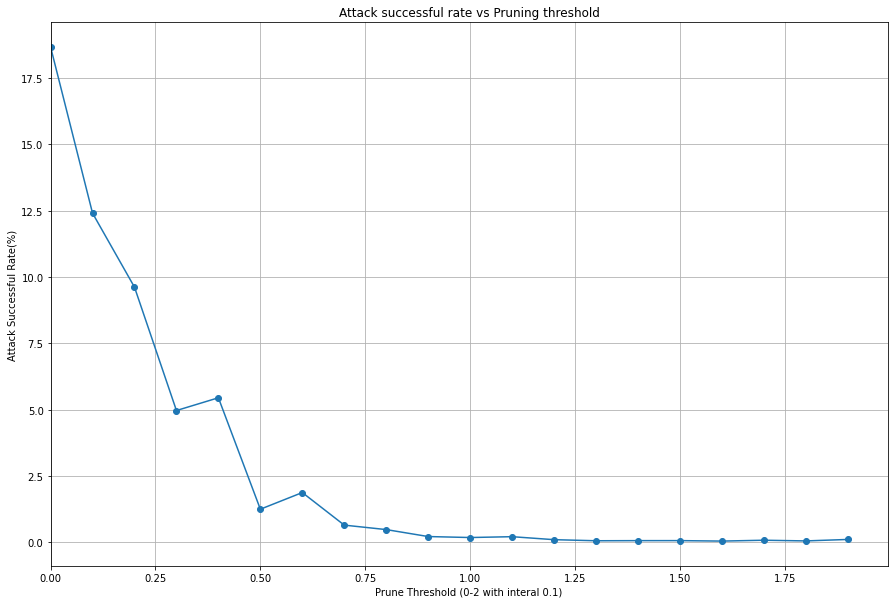

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(prune_threshold, (np.array(asr_sunglasses)+np.array(asr_anonymous_1)+np.array(asr_multi_trigger_multi_target))/3, '-o')
plt.title('Attack successful rate vs Pruning threshold')
plt.xlabel('Prune Threshold (0-2 with interal 0.1)')
plt.ylabel('Attack Successful Rate(%)')
plt.xlim(0,)
plt.grid('on')

## 3) Fine-tune with different LR

### sunglasses_bd_net model

In [ ]:
lrs = np.array([0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1])
cl_acc_sunglasses = []
asr_sunglasses = []
for lr in lrs:
  sunglasses_bd_model_pruned = keras.models.load_model('/content/CSAW-HackML-2020/models/sunglasses_bd_net.h5')
  conv_1_prune_list = prune_decision_flex_threshold(sunglasses_bd_model, 'pool_1', x_val_cl, 1)
  conv_2_prune_list = prune_decision_flex_threshold(sunglasses_bd_model, 'pool_2', x_val_cl, 1)
  conv_3_prune_list = prune_decision_flex_threshold(sunglasses_bd_model, 'pool_3', x_val_cl, 1)
  conv_4_prune_list = prune_decision_flex_threshold(sunglasses_bd_model, 'conv_4', x_val_cl, 1)
  
  prune(sunglasses_bd_model_pruned, 'conv_1', conv_1_prune_list)
  prune(sunglasses_bd_model_pruned, 'conv_2', conv_2_prune_list)
  prune(sunglasses_bd_model_pruned, 'conv_3', conv_3_prune_list)
  prune(sunglasses_bd_model_pruned, 'conv_4', conv_4_prune_list)

  loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  sunglasses_bd_model_pruned.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),loss=loss_func,metrics=['accuracy'])
  # retraining
  sunglasses_bd_model_pruned.fit(x_val_cl, y_val_cl, epochs=10)

  sunglasses_gd_model = GoodNet(sunglasses_bd_model, sunglasses_bd_model_pruned)
  acc, attack_sr = evaluate_gd(sunglasses_gd_model, x_test_cl, y_test_cl, x_val_bd_sunglass, y_val_bd_sunglass);
  cl_acc_sunglasses.append(acc)
  asr_sunglasses.append(attack_sr)

Epoch 1/10
361/361 [==============================] - 3s 6ms/step - loss: 0.5673 - accuracy: 0.9000
Epoch 2/10
361/361 [==============================] - 2s 6ms/step - loss: 0.2251 - accuracy: 0.9723
Epoch 3/10
361/361 [==============================] - 2s 6ms/step - loss: 0.1413 - accuracy: 0.9859
Epoch 4/10
361/361 [==============================] - 2s 6ms/step - loss: 0.0952 - accuracy: 0.9905
Epoch 5/10
361/361 [==============================] - 2s 6ms/step - loss: 0.0646 - accuracy: 0.9926
Epoch 6/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0406 - accuracy: 0.9941
Epoch 7/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0222 - accuracy: 0.9969
Epoch 8/10
361/361 [==============================] - 2s 6ms/step - loss: 0.0122 - accuracy: 0.9982
Epoch 9/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0085 - accuracy: 0.9985
Epoch 10/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0064 - accuracy: 0.9987

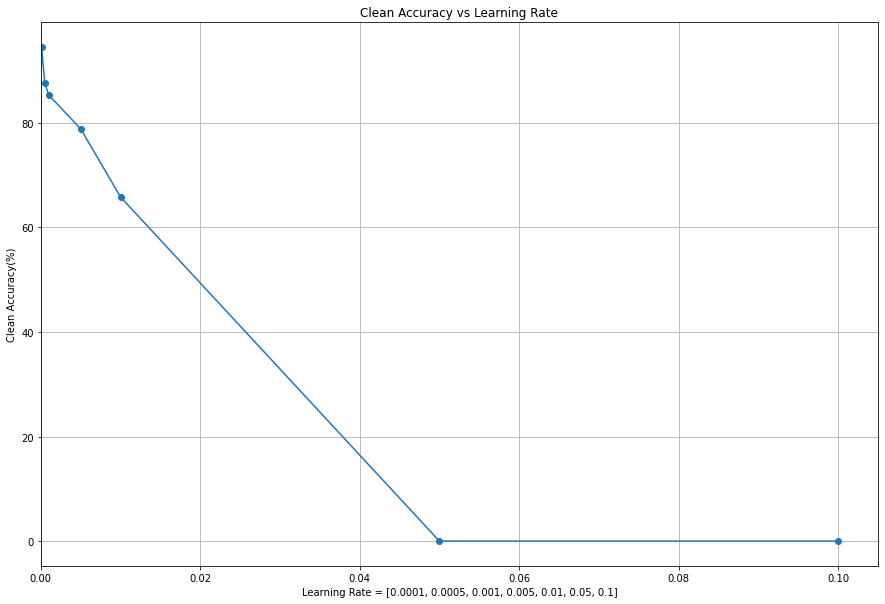

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(lrs, cl_acc_sunglasses, '-o')
plt.title('Clean Accuracy vs Learning Rate')
plt.xlabel('Learning Rate = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]')
plt.ylabel('Clean Accuracy(%)')
plt.xlim(0,)
plt.grid('on')

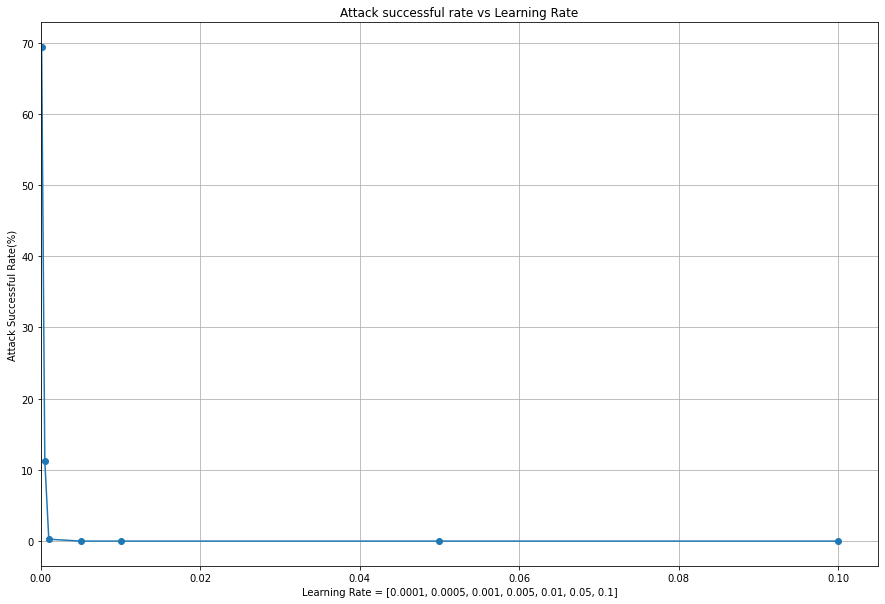

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(lrs, asr_sunglasses, '-o')
plt.title('Attack successful rate vs Learning Rate')
plt.xlabel('Learning Rate = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]')
plt.ylabel('Attack Successful Rate(%)')
plt.xlim(0,)
plt.grid('on')

### anonymous_1_bd_net

In [ ]:
lrs = np.array([0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1])
cl_acc_anonymous_1 = []
asr_anonymous_1 = []
for lr in lrs:
  anonymous_1_bd_model_pruned = keras.models.load_model('/content/CSAW-HackML-2020/models/anonymous_1_bd_net.h5')
  conv_1_prune_list = prune_decision_flex_threshold(anonymous_1_bd_model_pruned, 'pool_1', x_val_cl, 1)
  conv_2_prune_list = prune_decision_flex_threshold(anonymous_1_bd_model_pruned, 'pool_2', x_val_cl, 1)
  conv_3_prune_list = prune_decision_flex_threshold(anonymous_1_bd_model_pruned, 'pool_3', x_val_cl, 1)
  conv_4_prune_list = prune_decision_flex_threshold(anonymous_1_bd_model_pruned, 'conv_4', x_val_cl, 1)
  
  prune(anonymous_1_bd_model_pruned, 'conv_1', conv_1_prune_list)
  prune(anonymous_1_bd_model_pruned, 'conv_2', conv_2_prune_list)
  prune(anonymous_1_bd_model_pruned, 'conv_3', conv_3_prune_list)
  prune(anonymous_1_bd_model_pruned, 'conv_4', conv_4_prune_list)

  loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  anonymous_1_bd_model_pruned.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),loss=loss_func,metrics=['accuracy'])
  # retraining
  anonymous_1_bd_model_pruned.fit(x_val_cl, y_val_cl, epochs=10)

  anonymous_1_gd_model = GoodNet(anonymous_1_bd_model, anonymous_1_bd_model_pruned)
  acc, attack_sr = evaluate_gd(anonymous_1_gd_model, x_test_cl, y_test_cl, x_val_bd_anonymous_1, y_val_bd_anonymous_1);
  cl_acc_anonymous_1.append(acc)
  asr_anonymous_1.append(attack_sr)

Epoch 1/10
361/361 [==============================] - 3s 6ms/step - loss: 1.0272 - accuracy: 0.8121
Epoch 2/10
361/361 [==============================] - 2s 6ms/step - loss: 0.3360 - accuracy: 0.9360
Epoch 3/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1986 - accuracy: 0.9705
Epoch 4/10
361/361 [==============================] - 2s 5ms/step - loss: 0.1313 - accuracy: 0.9836
Epoch 5/10
361/361 [==============================] - 2s 6ms/step - loss: 0.0910 - accuracy: 0.9901
Epoch 6/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0645 - accuracy: 0.9940
Epoch 7/10
361/361 [==============================] - 2s 6ms/step - loss: 0.0447 - accuracy: 0.9949
Epoch 8/10
361/361 [==============================] - 2s 6ms/step - loss: 0.0306 - accuracy: 0.9963
Epoch 9/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0187 - accuracy: 0.9975
Epoch 10/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0109 - accuracy: 0.9983

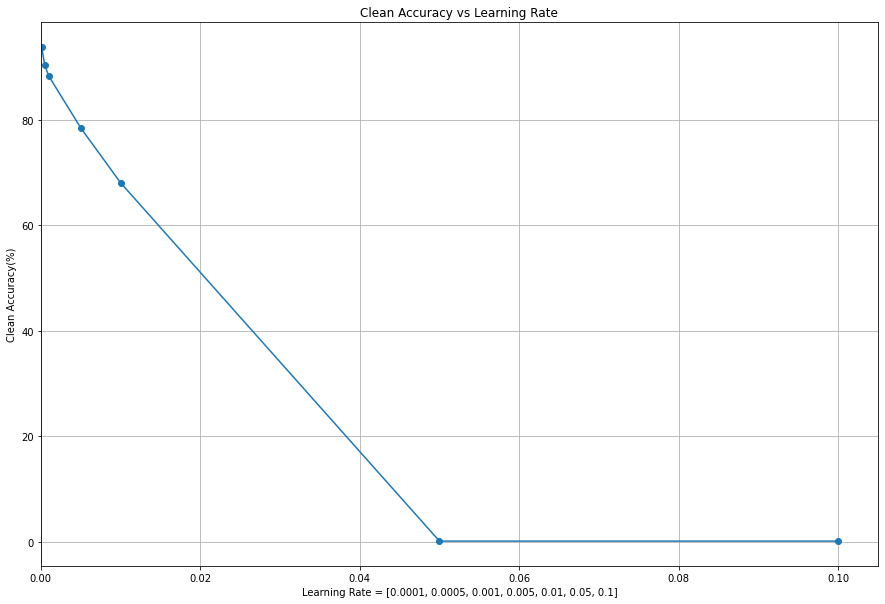

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(lrs, cl_acc_anonymous_1, '-o')
plt.title('Clean Accuracy vs Learning Rate')
plt.xlabel('Learning Rate = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]')
plt.ylabel('Clean Accuracy(%)')
plt.xlim(0,)
plt.grid('on')

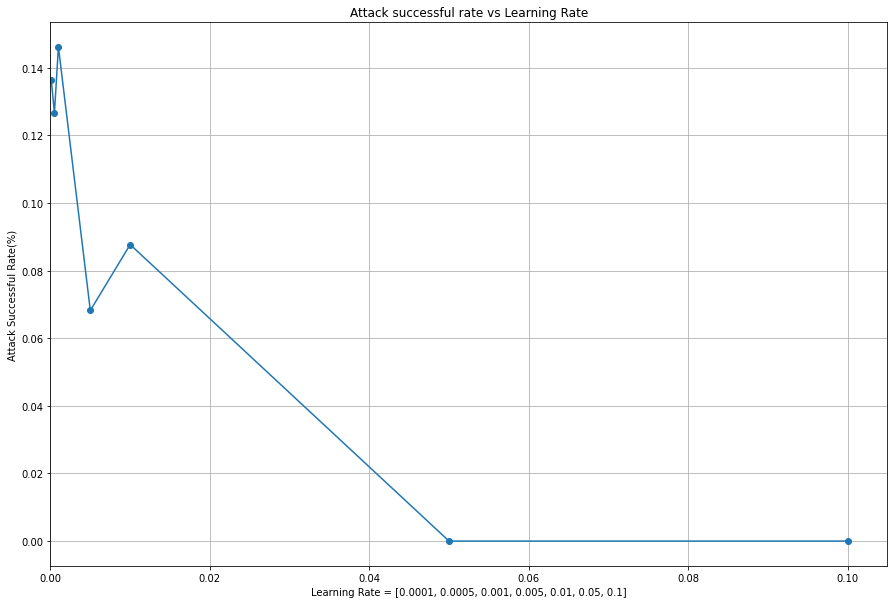

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(lrs, asr_anonymous_1, '-o')
plt.title('Attack successful rate vs Learning Rate')
plt.xlabel('Learning Rate = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]')
plt.ylabel('Attack Successful Rate(%)')
plt.xlim(0,)
plt.grid('on')

### multi_trigger_multi_target_bd_net

In [ ]:
lrs = np.array([0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1])
cl_acc_multi_trigger_multi_target = []
asr_multi_trigger_multi_target = []
for lr in lrs:
  multi_trigger_multi_target_bd_model_pruned = keras.models.load_model('/content/CSAW-HackML-2020/models/multi_trigger_multi_target_bd_net.h5')
  conv_1_prune_list = prune_decision_flex_threshold(multi_trigger_multi_target_bd_model_pruned, 'pool_1', x_val_cl, 1)
  conv_2_prune_list = prune_decision_flex_threshold(multi_trigger_multi_target_bd_model_pruned, 'pool_2', x_val_cl, 1)
  conv_3_prune_list = prune_decision_flex_threshold(multi_trigger_multi_target_bd_model_pruned, 'pool_3', x_val_cl, 1)
  conv_4_prune_list = prune_decision_flex_threshold(multi_trigger_multi_target_bd_model_pruned, 'conv_4', x_val_cl, 1)
  
  prune(multi_trigger_multi_target_bd_model_pruned, 'conv_1', conv_1_prune_list)
  prune(multi_trigger_multi_target_bd_model_pruned, 'conv_2', conv_2_prune_list)
  prune(multi_trigger_multi_target_bd_model_pruned, 'conv_3', conv_3_prune_list)
  prune(multi_trigger_multi_target_bd_model_pruned, 'conv_4', conv_4_prune_list)

  loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  multi_trigger_multi_target_bd_model_pruned.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),loss=loss_func,metrics=['accuracy'])
  # retraining
  multi_trigger_multi_target_bd_model_pruned.fit(x_val_cl, y_val_cl, epochs=10)

  multi_trigger_multi_target_gd_model = GoodNet(multi_trigger_multi_target_bd_model, multi_trigger_multi_target_bd_model_pruned)
  
  acc_multi_sunglasses, attack_sr_multi_sunglasses = evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_sunglasses, y_val_bd_multi_sunglasses);
  acc_multi_eyebrows, attack_sr_multi_eyebrows = evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_eyebrows, y_val_bd_multi_eyebrows);
  acc_multi_lipstick, attack_sr_multi_lipstick = evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_lipstick, y_val_bd_multi_lipstick);
  cl_acc_multi_trigger_multi_target.append((acc_multi_sunglasses + acc_multi_eyebrows + acc_multi_lipstick)/3)
  asr_multi_trigger_multi_target.append((attack_sr_multi_sunglasses + attack_sr_multi_eyebrows + attack_sr_multi_lipstick)/3)

Epoch 1/10
361/361 [==============================] - 3s 5ms/step - loss: 0.9529 - accuracy: 0.8188
Epoch 2/10
361/361 [==============================] - 2s 5ms/step - loss: 0.2620 - accuracy: 0.9433
Epoch 3/10
361/361 [==============================] - 2s 6ms/step - loss: 0.1378 - accuracy: 0.9746
Epoch 4/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0773 - accuracy: 0.9881
Epoch 5/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0480 - accuracy: 0.9932
Epoch 6/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0303 - accuracy: 0.9958
Epoch 7/10
361/361 [==============================] - 2s 6ms/step - loss: 0.0203 - accuracy: 0.9968
Epoch 8/10
361/361 [==============================] - 2s 6ms/step - loss: 0.0128 - accuracy: 0.9973
Epoch 9/10
361/361 [==============================] - 2s 6ms/step - loss: 0.0099 - accuracy: 0.9984
Epoch 10/10
361/361 [==============================] - 2s 5ms/step - loss: 0.0059 - accuracy: 0.9991

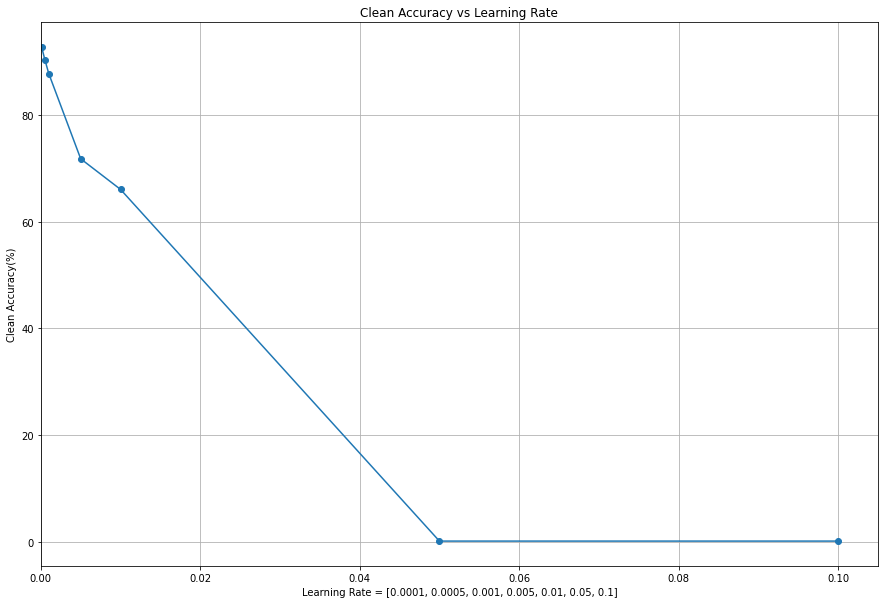

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(lrs, cl_acc_multi_trigger_multi_target, '-o')
plt.title('Clean Accuracy vs Learning Rate')
plt.xlabel('Learning Rate = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]')
plt.ylabel('Clean Accuracy(%)')
plt.xlim(0,)
plt.grid('on')

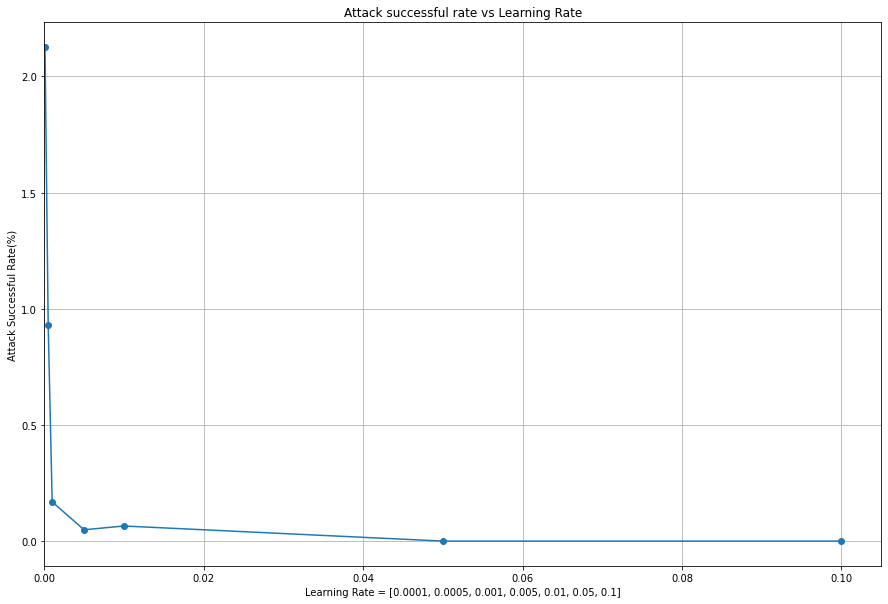

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(lrs, asr_multi_trigger_multi_target, '-o')
plt.title('Attack successful rate vs Learning Rate')
plt.xlabel('Learning Rate = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]')
plt.ylabel('Attack Successful Rate(%)')
plt.xlim(0,)
plt.grid('on')

### Average

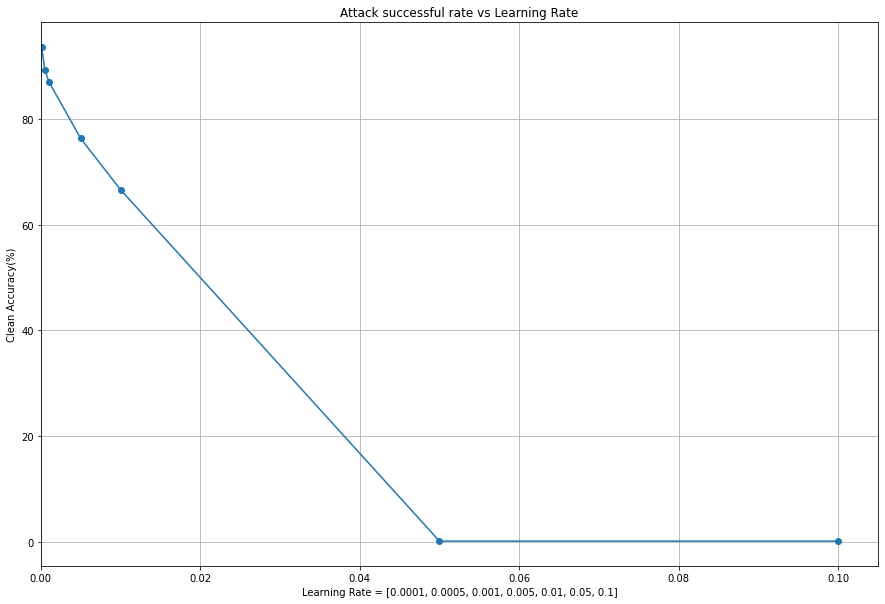

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(lrs, (np.array(cl_acc_sunglasses)+np.array(cl_acc_anonymous_1)+np.array(cl_acc_multi_trigger_multi_target))/3, '-o')
plt.title('Attack successful rate vs Learning Rate')
plt.xlabel('Learning Rate = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]')
plt.ylabel('Clean Accuracy(%)')
plt.xlim(0,)
plt.grid('on')

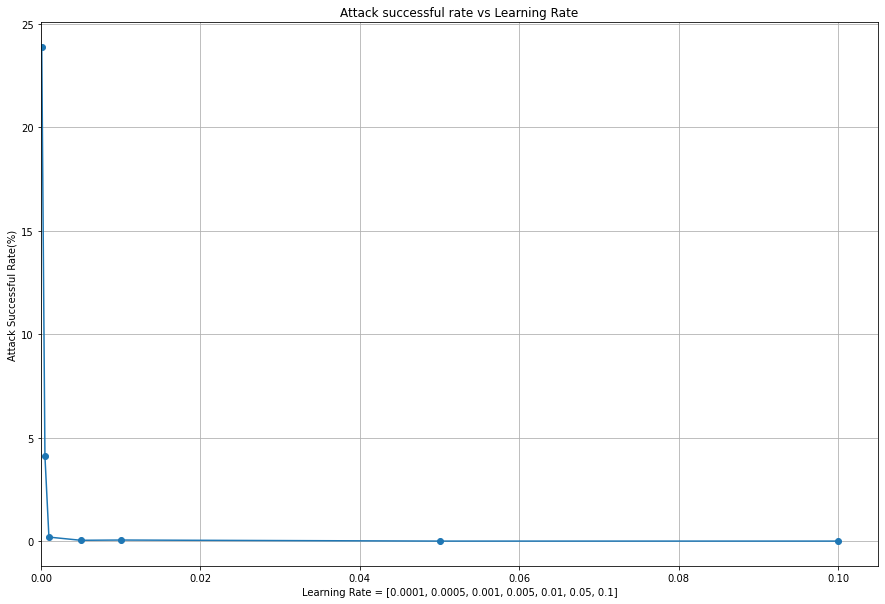

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(lrs, (np.array(asr_sunglasses)+np.array(asr_anonymous_1)+np.array(asr_multi_trigger_multi_target))/3, '-o')
plt.title('Attack successful rate vs Learning Rate')
plt.xlabel('Learning Rate = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]')
plt.ylabel('Attack Successful Rate(%)')
plt.xlim(0,)
plt.grid('on')

## 4) Fine-tune with different Epoch

### sunglasses_bd_net model

In [ ]:
cl_acc_sunglasses = [84.31021044427123, 84.78565861262666, 85.53390491036633, 83.64770070148091, 84.55962587685113, 84.80904130943102,86.66406858924395,85.33125487139517,
                     85.705378020265, 85.3078721745908, 85.5261106780982, 85.97038191738113, 84.24006235385815]
asr_sunglasses = [0.2260327357755261, 1.083398285268901, 0.4286827747466875, 4.567420109119252, 0.6313328137178488, 0.2883865939204988,0.39750584567420105,0.1402961808261886,
                  0.2727981293842557, 0.05455962587685113, 0.08573655494933749, 0.17926734216679657, 0.06235385814497272]

In [ ]:
epoches = np.array([4, 6, 8, 10, 12, 14, 16, 20, 24, 26, 30, 35, 40])
cl_acc_sunglasses = []
asr_sunglasses = []
for epoch in epoches:
  sunglasses_bd_model_pruned = keras.models.load_model('/content/CSAW-HackML-2020/models/sunglasses_bd_net.h5')
  conv_1_prune_list = prune_decision_flex_threshold(sunglasses_bd_model, 'pool_1', x_val_cl, 1)
  conv_2_prune_list = prune_decision_flex_threshold(sunglasses_bd_model, 'pool_2', x_val_cl, 1)
  conv_3_prune_list = prune_decision_flex_threshold(sunglasses_bd_model, 'pool_3', x_val_cl, 1)
  conv_4_prune_list = prune_decision_flex_threshold(sunglasses_bd_model, 'conv_4', x_val_cl, 1)
  
  prune(sunglasses_bd_model_pruned, 'conv_1', conv_1_prune_list)
  prune(sunglasses_bd_model_pruned, 'conv_2', conv_2_prune_list)
  prune(sunglasses_bd_model_pruned, 'conv_3', conv_3_prune_list)
  prune(sunglasses_bd_model_pruned, 'conv_4', conv_4_prune_list)

  loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  sunglasses_bd_model_pruned.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss=loss_func,metrics=['accuracy'])
  # retraining
  sunglasses_bd_model_pruned.fit(x_val_cl, y_val_cl, epochs=epoch)

  sunglasses_gd_model = GoodNet(sunglasses_bd_model, sunglasses_bd_model_pruned)
  acc, attack_sr = evaluate_gd(sunglasses_gd_model, x_test_cl, y_test_cl, x_val_bd_sunglass, y_val_bd_sunglass);
  cl_acc_sunglasses.append(acc)
  asr_sunglasses.append(attack_sr)

Epoch 1/4
361/361 [==============================] - 3s 5ms/step - loss: 1.2214 - accuracy: 0.7560
Epoch 2/4
361/361 [==============================] - 2s 6ms/step - loss: 0.3160 - accuracy: 0.9238
Epoch 3/4
361/361 [==============================] - 2s 6ms/step - loss: 0.2207 - accuracy: 0.9415
Epoch 4/4
361/361 [==============================] - 2s 6ms/step - loss: 0.1896 - accuracy: 0.9468
Clean accuracy: 84.31021044427123
Attack success rate: 0.2260327357755261
Epoch 1/6
361/361 [==============================] - 3s 6ms/step - loss: 1.2342 - accuracy: 0.7537
Epoch 2/6
361/361 [==============================] - 2s 6ms/step - loss: 0.3234 - accuracy: 0.9249
Epoch 3/6
361/361 [==============================] - 2s 7ms/step - loss: 0.2170 - accuracy: 0.9423
Epoch 4/6
361/361 [==============================] - 2s 5ms/step - loss: 0.1894 - accuracy: 0.9459
Epoch 5/6
361/361 [==============================] - 2s 5ms/step - loss: 0.1283 - accuracy: 0.9652
Epoch 6/6
361/361 [================

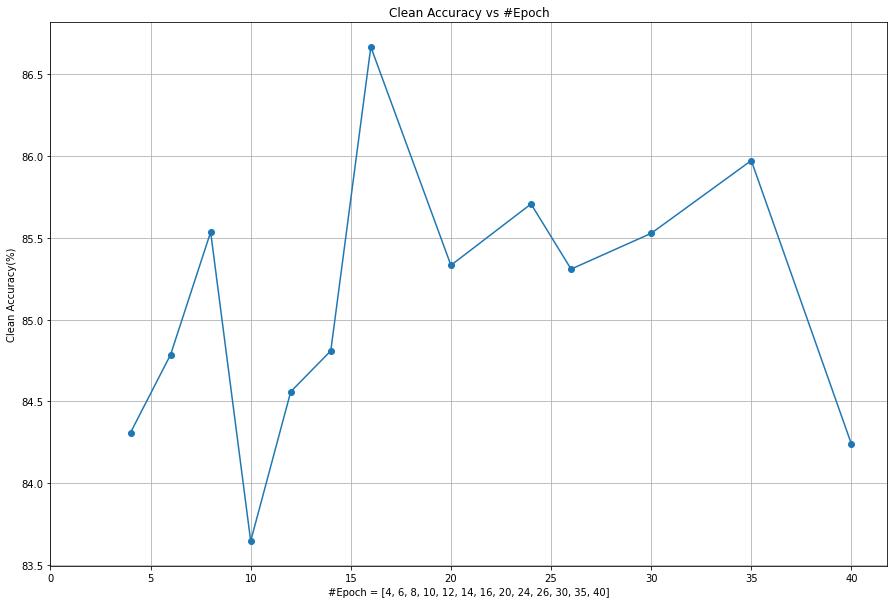

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(epoches, cl_acc_sunglasses, '-o')
plt.title('Clean Accuracy vs #Epoch')
plt.xlabel('#Epoch = [4, 6, 8, 10, 12, 14, 16, 20, 24, 26, 30, 35, 40]')
plt.ylabel('Clean Accuracy(%)')
plt.xlim(0,)
plt.grid('on')

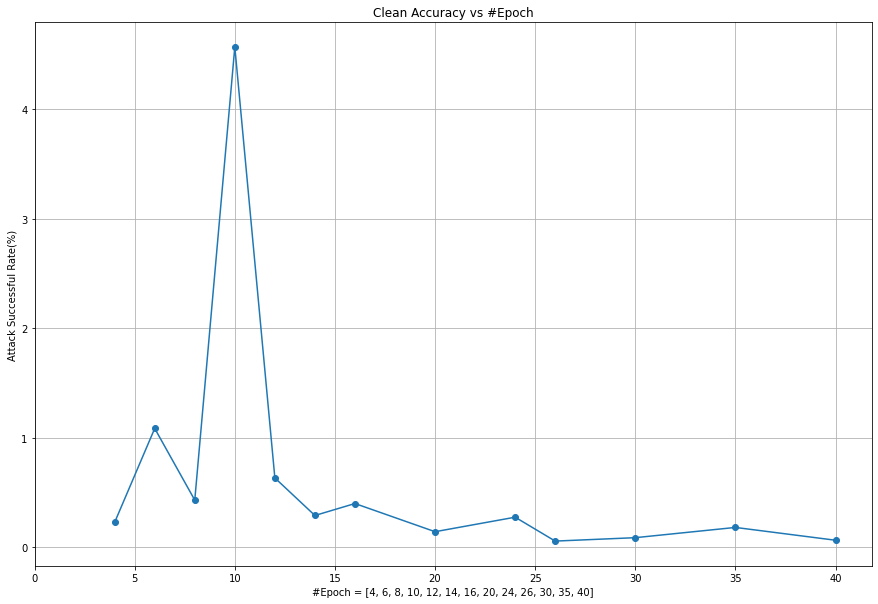

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(epoches, asr_sunglasses, '-o')
plt.title('Clean Accuracy vs #Epoch')
plt.xlabel('#Epoch = [4, 6, 8, 10, 12, 14, 16, 20, 24, 26, 30, 35, 40]')
plt.ylabel('Attack Successful Rate(%)')
plt.xlim(0,)
plt.grid('on')

### anonymous_1_bd_net

In [ ]:
cl_acc_anonymous_1 = [86.82774746687451, 86.7186282151208, 85.82229150428682, 86.62509742790336, 86.61730319563523, 87.41231488698364,86.91348402182385,87.17848791893998,
                     87.48246297739672, 87.40452065471551, 85.9937646141855, 87.72408417770849, 86.97583787996882]
asr_anonymous_1 = [0.10717069368667187, 0.0779423226812159, 0.08768511301636789, 0.08768511301636789, 0.17537022603273578, 0.2533125487139517,0.08768511301636789,0.08768511301636789,
                  0.08768511301636789, 0.1461418550272798, 0.0779423226812159, 0.08768511301636789, 0.08768511301636789]

In [ ]:
epoches = np.array([4, 6, 8, 10, 12, 14, 16, 20, 24, 26, 30, 35, 40])
cl_acc_anonymous_1 = []
asr_anonymous_1 = []
for epoch in epoches:
  anonymous_1_bd_model_pruned = keras.models.load_model('/content/CSAW-HackML-2020/models/anonymous_1_bd_net.h5')
  conv_1_prune_list = prune_decision_flex_threshold(anonymous_1_bd_model_pruned, 'pool_1', x_val_cl, 1)
  conv_2_prune_list = prune_decision_flex_threshold(anonymous_1_bd_model_pruned, 'pool_2', x_val_cl, 1)
  conv_3_prune_list = prune_decision_flex_threshold(anonymous_1_bd_model_pruned, 'pool_3', x_val_cl, 1)
  conv_4_prune_list = prune_decision_flex_threshold(anonymous_1_bd_model_pruned, 'conv_4', x_val_cl, 1)
  
  prune(anonymous_1_bd_model_pruned, 'conv_1', conv_1_prune_list)
  prune(anonymous_1_bd_model_pruned, 'conv_2', conv_2_prune_list)
  prune(anonymous_1_bd_model_pruned, 'conv_3', conv_3_prune_list)
  prune(anonymous_1_bd_model_pruned, 'conv_4', conv_4_prune_list)

  loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  anonymous_1_bd_model_pruned.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss=loss_func,metrics=['accuracy'])
  # retraining
  anonymous_1_bd_model_pruned.fit(x_val_cl, y_val_cl, epochs=epoch)

  anonymous_1_gd_model = GoodNet(anonymous_1_bd_model, anonymous_1_bd_model_pruned)
  acc, attack_sr = evaluate_gd(anonymous_1_gd_model, x_test_cl, y_test_cl, x_val_bd_anonymous_1, y_val_bd_anonymous_1);
  cl_acc_anonymous_1.append(acc)
  asr_anonymous_1.append(attack_sr)

Epoch 1/4
361/361 [==============================] - 3s 5ms/step - loss: 0.9249 - accuracy: 0.8057
Epoch 2/4
361/361 [==============================] - 2s 5ms/step - loss: 0.1866 - accuracy: 0.9570
Epoch 3/4
361/361 [==============================] - 2s 5ms/step - loss: 0.1611 - accuracy: 0.9555
Epoch 4/4
361/361 [==============================] - 2s 5ms/step - loss: 0.1277 - accuracy: 0.9658
Clean accuracy: 86.82774746687451
Attack success rate: 0.10717069368667187
Epoch 1/6
361/361 [==============================] - 3s 5ms/step - loss: 0.9342 - accuracy: 0.8052
Epoch 2/6
361/361 [==============================] - 2s 5ms/step - loss: 0.1805 - accuracy: 0.9558
Epoch 3/6
361/361 [==============================] - 2s 5ms/step - loss: 0.1616 - accuracy: 0.9575
Epoch 4/6
361/361 [==============================] - 2s 5ms/step - loss: 0.1342 - accuracy: 0.9624
Epoch 5/6
361/361 [==============================] - 2s 5ms/step - loss: 0.1191 - accuracy: 0.9677
Epoch 6/6
361/361 [===============

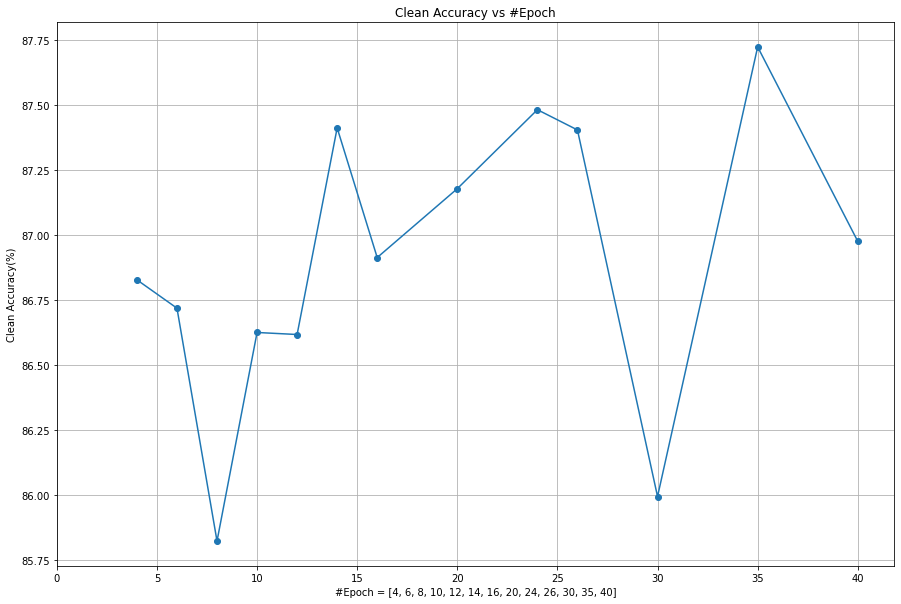

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(epoches, cl_acc_anonymous_1, '-o')
plt.title('Clean Accuracy vs #Epoch')
plt.xlabel('#Epoch = [4, 6, 8, 10, 12, 14, 16, 20, 24, 26, 30, 35, 40]')
plt.ylabel('Clean Accuracy(%)')
plt.xlim(0,)
plt.grid('on')

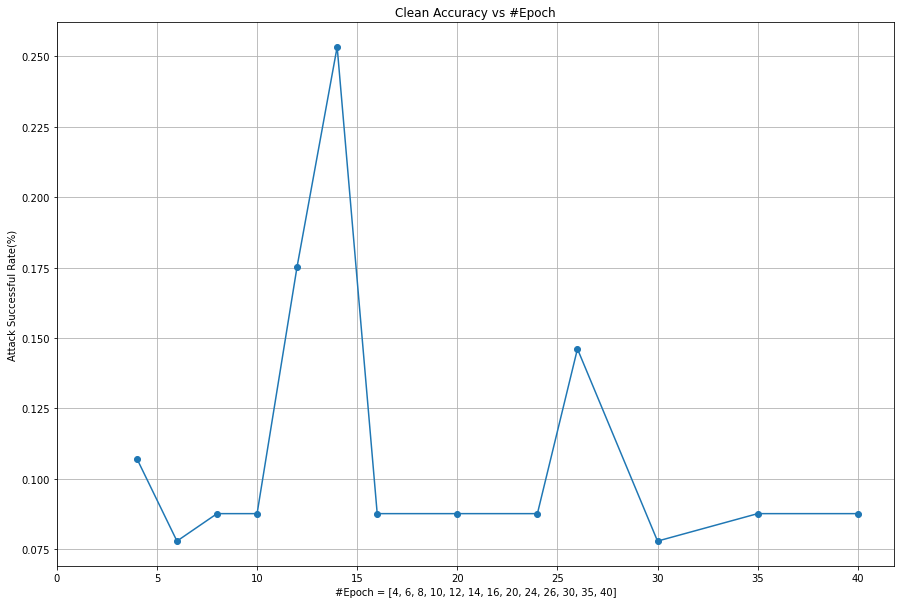

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(epoches, asr_anonymous_1, '-o')
plt.title('Clean Accuracy vs #Epoch')
plt.xlabel('#Epoch = [4, 6, 8, 10, 12, 14, 16, 20, 24, 26, 30, 35, 40]')
plt.ylabel('Attack Successful Rate(%)')
plt.xlim(0,)
plt.grid('on')

### multi_trigger_multi_target_bd_net

In [ ]:
epoches = np.array([4, 6, 8, 10, 12, 14, 16, 20, 24, 26, 30, 35, 40])
cl_acc_multi_trigger_multi_target = []
asr_multi_trigger_multi_target = []
K.clear_session()
for epoch in epoches:
  multi_trigger_multi_target_bd_model_pruned = keras.models.load_model('/content/CSAW-HackML-2020/models/multi_trigger_multi_target_bd_net.h5')
  conv_1_prune_list = prune_decision_flex_threshold(multi_trigger_multi_target_bd_model_pruned, 'pool_1', x_val_cl, 1)
  conv_2_prune_list = prune_decision_flex_threshold(multi_trigger_multi_target_bd_model_pruned, 'pool_2', x_val_cl, 1)
  conv_3_prune_list = prune_decision_flex_threshold(multi_trigger_multi_target_bd_model_pruned, 'pool_3', x_val_cl, 1)
  conv_4_prune_list = prune_decision_flex_threshold(multi_trigger_multi_target_bd_model_pruned, 'conv_4', x_val_cl, 1)
  
  prune(multi_trigger_multi_target_bd_model_pruned, 'conv_1', conv_1_prune_list)
  prune(multi_trigger_multi_target_bd_model_pruned, 'conv_2', conv_2_prune_list)
  prune(multi_trigger_multi_target_bd_model_pruned, 'conv_3', conv_3_prune_list)
  prune(multi_trigger_multi_target_bd_model_pruned, 'conv_4', conv_4_prune_list)

  loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  multi_trigger_multi_target_bd_model_pruned.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss=loss_func,metrics=['accuracy'])
  # retraining
  multi_trigger_multi_target_bd_model_pruned.fit(x_val_cl, y_val_cl, epochs=epoch)

  multi_trigger_multi_target_gd_model = GoodNet(multi_trigger_multi_target_bd_model, multi_trigger_multi_target_bd_model_pruned)
  
  acc_multi_sunglasses, attack_sr_multi_sunglasses = evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_sunglasses, y_val_bd_multi_sunglasses);
  acc_multi_eyebrows, attack_sr_multi_eyebrows = evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_eyebrows, y_val_bd_multi_eyebrows);
  acc_multi_lipstick, attack_sr_multi_lipstick = evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_lipstick, y_val_bd_multi_lipstick);
  cl_acc_multi_trigger_multi_target.append((acc_multi_sunglasses + acc_multi_eyebrows + acc_multi_lipstick)/3)
  asr_multi_trigger_multi_target.append((attack_sr_multi_sunglasses + attack_sr_multi_eyebrows + attack_sr_multi_lipstick)/3)

Epoch 1/4
361/361 [==============================] - 3s 5ms/step - loss: 0.8126 - accuracy: 0.8175
Epoch 2/4
361/361 [==============================] - 2s 5ms/step - loss: 0.1571 - accuracy: 0.9585
Epoch 3/4
361/361 [==============================] - 2s 5ms/step - loss: 0.1049 - accuracy: 0.9688
Epoch 4/4
361/361 [==============================] - 2s 5ms/step - loss: 0.1176 - accuracy: 0.9672
Clean accuracy: 86.43024162120031
Attack success rate: 0.009742790335151987
Clean accuracy: 86.43024162120031
Attack success rate: 4.325798908807482
Clean accuracy: 86.43024162120031
Attack success rate: 0.1558846453624318
Epoch 1/6
361/361 [==============================] - 3s 5ms/step - loss: 0.8336 - accuracy: 0.8117
Epoch 2/6
361/361 [==============================] - 2s 5ms/step - loss: 0.1523 - accuracy: 0.9597
Epoch 3/6
361/361 [==============================] - 2s 5ms/step - loss: 0.1178 - accuracy: 0.9667
Epoch 4/6
361/361 [==============================] - 2s 5ms/step - loss: 0.1138 - ac

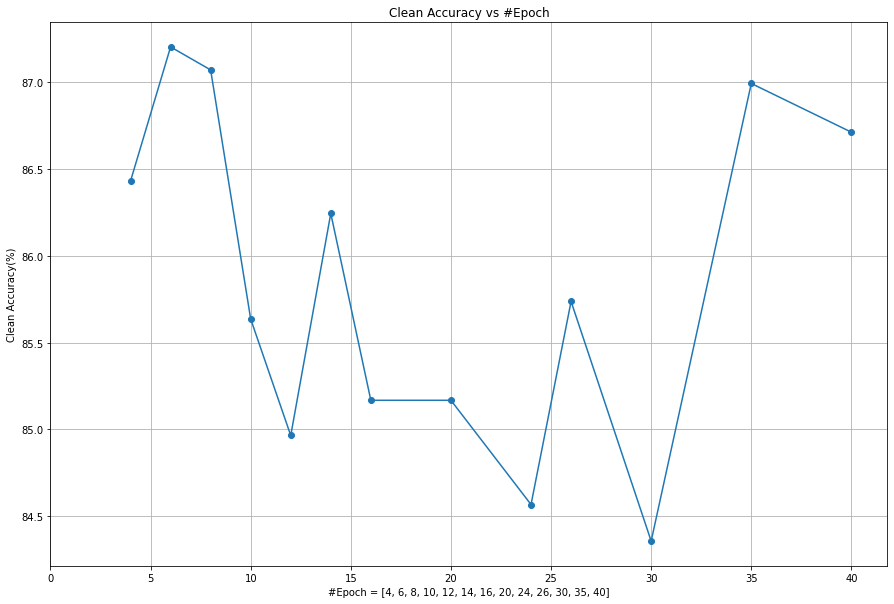

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(epoches, cl_acc_multi_trigger_multi_target, '-o')
plt.title('Clean Accuracy vs #Epoch')
plt.xlabel('#Epoch = [4, 6, 8, 10, 12, 14, 16, 20, 24, 26, 30, 35, 40]')
plt.ylabel('Clean Accuracy(%)')
plt.xlim(0,)
plt.grid('on')

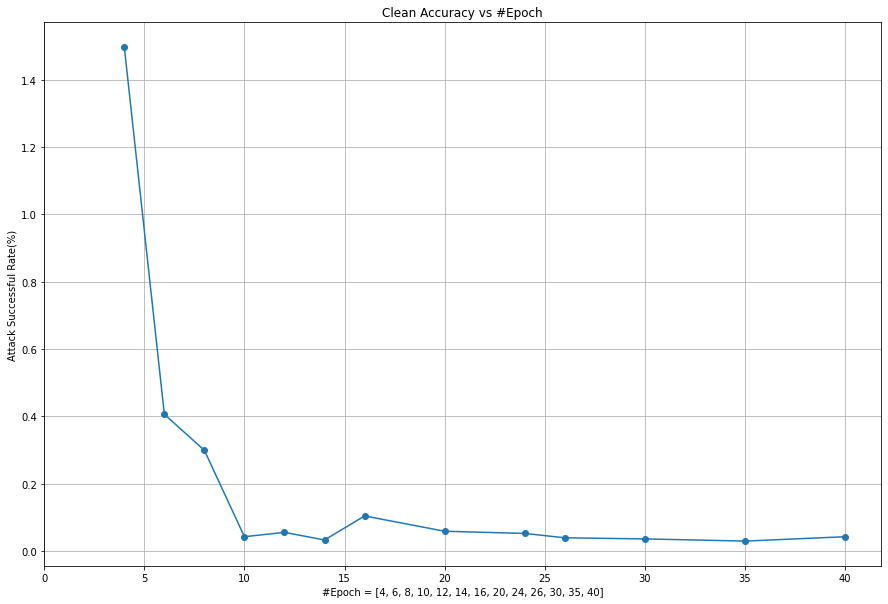

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(epoches, asr_multi_trigger_multi_target, '-o')
plt.title('Clean Accuracy vs #Epoch')
plt.xlabel('#Epoch = [4, 6, 8, 10, 12, 14, 16, 20, 24, 26, 30, 35, 40]')
plt.ylabel('Attack Successful Rate(%)')
plt.xlim(0,)
plt.grid('on')

### Average

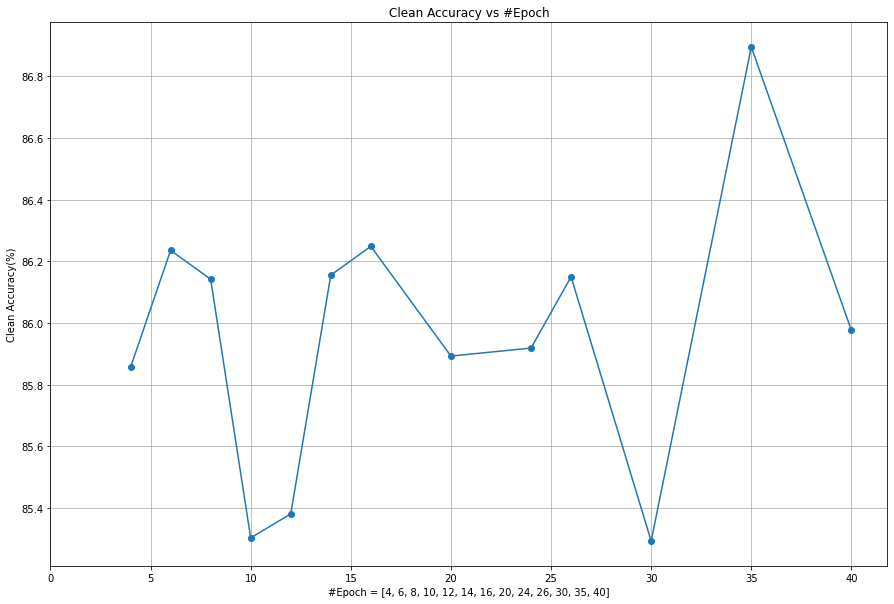

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(epoches, (np.array(cl_acc_sunglasses)+np.array(cl_acc_anonymous_1)+np.array(cl_acc_multi_trigger_multi_target))/3, '-o')
plt.title('Clean Accuracy vs #Epoch')
plt.xlabel('#Epoch = [4, 6, 8, 10, 12, 14, 16, 20, 24, 26, 30, 35, 40]')
plt.ylabel('Clean Accuracy(%)')
plt.xlim(0,)
plt.grid('on')

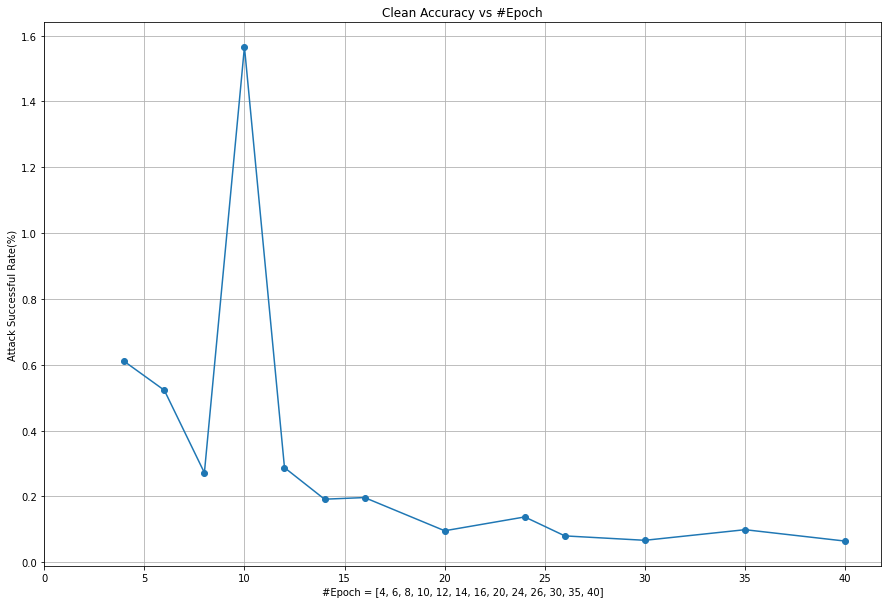

In [ ]:
from matplotlib import markers
plt.figure(figsize=(15,10))
plt.plot(epoches, (np.array(asr_sunglasses)+np.array(asr_anonymous_1)+np.array(asr_multi_trigger_multi_target))/3, '-o')
plt.title('Clean Accuracy vs #Epoch')
plt.xlabel('#Epoch = [4, 6, 8, 10, 12, 14, 16, 20, 24, 26, 30, 35, 40]')
plt.ylabel('Attack Successful Rate(%)')
plt.xlim(0,)
plt.grid('on')

## 5) Grid Search

### sunglasses_bd_net model

In [ ]:
prune_threshold = np.array([0.8, 1.0, 1.2])
lrs = np.array([0.001, 0.003, 0.005])
epoches = np.array([30, 33, 35])
cl_acc_sunglasses = []
asr_sunglasses = []
for threshold in prune_threshold:
  for lr in lrs:
    for epoch in epoches:
      sunglasses_bd_model_pruned = keras.models.load_model('/content/CSAW-HackML-2020/models/sunglasses_bd_net.h5')
      conv_1_prune_list = prune_decision_flex_threshold(sunglasses_bd_model, 'pool_1', x_val_cl, threshold)
      conv_2_prune_list = prune_decision_flex_threshold(sunglasses_bd_model, 'pool_2', x_val_cl, threshold)
      conv_3_prune_list = prune_decision_flex_threshold(sunglasses_bd_model, 'pool_3', x_val_cl, threshold)
      conv_4_prune_list = prune_decision_flex_threshold(sunglasses_bd_model, 'conv_4', x_val_cl, threshold)
      
      prune(sunglasses_bd_model_pruned, 'conv_1', conv_1_prune_list)
      prune(sunglasses_bd_model_pruned, 'conv_2', conv_2_prune_list)
      prune(sunglasses_bd_model_pruned, 'conv_3', conv_3_prune_list)
      prune(sunglasses_bd_model_pruned, 'conv_4', conv_4_prune_list)

      loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
      sunglasses_bd_model_pruned.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),loss=loss_func,metrics=['accuracy'])
      # retraining
      sunglasses_bd_model_pruned.fit(x_val_cl, y_val_cl, epochs=epoch)

      sunglasses_gd_model = GoodNet(sunglasses_bd_model, sunglasses_bd_model_pruned)
      acc, attack_sr = evaluate_gd(sunglasses_gd_model, x_test_cl, y_test_cl, x_val_bd_sunglass, y_val_bd_sunglass);
      cl_acc_sunglasses.append(acc)
      asr_sunglasses.append(attack_sr)

Epoch 1/30
361/361 [==============================] - 3s 5ms/step - loss: 1.1576 - accuracy: 0.7736
Epoch 2/30
361/361 [==============================] - 2s 5ms/step - loss: 0.3030 - accuracy: 0.9263
Epoch 3/30
361/361 [==============================] - 2s 5ms/step - loss: 0.2323 - accuracy: 0.9358
Epoch 4/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1802 - accuracy: 0.9485
Epoch 5/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1377 - accuracy: 0.9630
Epoch 6/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1446 - accuracy: 0.9591
Epoch 7/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1046 - accuracy: 0.9712
Epoch 8/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1130 - accuracy: 0.9703
Epoch 9/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1026 - accuracy: 0.9709
Epoch 10/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0898 - accuracy: 0.9753

In [ ]:
np.savetxt('cl_acc_sunglasses.csv', np.array(cl_acc_sunglasses), delimiter = ',')
np.savetxt('asr_sunglasses.csv', np.array(asr_sunglasses), delimiter = ',')

### anonymous_1_bd_net

In [ ]:
prune_threshold = np.array([0.8, 1.0, 1.2])
lrs = np.array([0.001, 0.003, 0.005])
epoches = np.array([30, 33, 35])
cl_acc_anonymous_1 = []
asr_anonymous_1 = []
for threshold in prune_threshold:
  for lr in lrs:
    for epoch in epoches:
      anonymous_1_bd_model_pruned = keras.models.load_model('/content/CSAW-HackML-2020/models/anonymous_1_bd_net.h5')
      conv_1_prune_list = prune_decision_flex_threshold(anonymous_1_bd_model_pruned, 'pool_1', x_val_cl, threshold)
      conv_2_prune_list = prune_decision_flex_threshold(anonymous_1_bd_model_pruned, 'pool_2', x_val_cl, threshold)
      conv_3_prune_list = prune_decision_flex_threshold(anonymous_1_bd_model_pruned, 'pool_3', x_val_cl, threshold)
      conv_4_prune_list = prune_decision_flex_threshold(anonymous_1_bd_model_pruned, 'conv_4', x_val_cl, threshold)
      
      prune(anonymous_1_bd_model_pruned, 'conv_1', conv_1_prune_list)
      prune(anonymous_1_bd_model_pruned, 'conv_2', conv_2_prune_list)
      prune(anonymous_1_bd_model_pruned, 'conv_3', conv_3_prune_list)
      prune(anonymous_1_bd_model_pruned, 'conv_4', conv_4_prune_list)

      loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
      anonymous_1_bd_model_pruned.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),loss=loss_func,metrics=['accuracy'])
      # retraining
      anonymous_1_bd_model_pruned.fit(x_val_cl, y_val_cl, epochs=epoch)

      anonymous_1_gd_model = GoodNet(anonymous_1_bd_model, anonymous_1_bd_model_pruned)
      acc, attack_sr = evaluate_gd(anonymous_1_gd_model, x_test_cl, y_test_cl, x_val_bd_anonymous_1, y_val_bd_anonymous_1);
      cl_acc_anonymous_1.append(acc)
      asr_anonymous_1.append(attack_sr)

Epoch 1/30
361/361 [==============================] - 3s 5ms/step - loss: 0.6902 - accuracy: 0.8485
Epoch 2/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1624 - accuracy: 0.9596
Epoch 3/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1476 - accuracy: 0.9594
Epoch 4/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1227 - accuracy: 0.9649
Epoch 5/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1079 - accuracy: 0.9710
Epoch 6/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0864 - accuracy: 0.9747
Epoch 7/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0854 - accuracy: 0.9754
Epoch 8/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0747 - accuracy: 0.9802
Epoch 9/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0651 - accuracy: 0.9824
Epoch 10/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0712 - accuracy: 0.9792

In [ ]:
np.savetxt('cl_acc_anonymous_1.csv', np.array(cl_acc_anonymous_1), delimiter = ',')
np.savetxt('asr_anonymous_1.csv', np.array(asr_anonymous_1), delimiter = ',')

### multi_trigger_multi_target_bd_net

In [ ]:
prune_threshold = np.array([0.8, 1.0, 1.2])
lrs = np.array([0.001, 0.003, 0.005])
epoches = np.array([30, 33, 35])
cl_acc_multi_trigger_multi_target = []
asr_multi_trigger_multi_target = []
for threshold in prune_threshold:
  for lr in lrs:
    for epoch in epoches:
      multi_trigger_multi_target_bd_model_pruned = keras.models.load_model('/content/CSAW-HackML-2020/models/multi_trigger_multi_target_bd_net.h5')
      conv_1_prune_list = prune_decision_flex_threshold(multi_trigger_multi_target_bd_model_pruned, 'pool_1', x_val_cl, threshold)
      conv_2_prune_list = prune_decision_flex_threshold(multi_trigger_multi_target_bd_model_pruned, 'pool_2', x_val_cl, threshold)
      conv_3_prune_list = prune_decision_flex_threshold(multi_trigger_multi_target_bd_model_pruned, 'pool_3', x_val_cl, threshold)
      conv_4_prune_list = prune_decision_flex_threshold(multi_trigger_multi_target_bd_model_pruned, 'conv_4', x_val_cl, threshold)
      
      prune(multi_trigger_multi_target_bd_model_pruned, 'conv_1', conv_1_prune_list)
      prune(multi_trigger_multi_target_bd_model_pruned, 'conv_2', conv_2_prune_list)
      prune(multi_trigger_multi_target_bd_model_pruned, 'conv_3', conv_3_prune_list)
      prune(multi_trigger_multi_target_bd_model_pruned, 'conv_4', conv_4_prune_list)

      loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
      multi_trigger_multi_target_bd_model_pruned.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),loss=loss_func,metrics=['accuracy'])
      # retraining
      multi_trigger_multi_target_bd_model_pruned.fit(x_val_cl, y_val_cl, epochs=epoch)

      multi_trigger_multi_target_gd_model = GoodNet(multi_trigger_multi_target_bd_model, multi_trigger_multi_target_bd_model_pruned)
      
      acc_multi_sunglasses, attack_sr_multi_sunglasses = evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_sunglasses, y_val_bd_multi_sunglasses);
      acc_multi_eyebrows, attack_sr_multi_eyebrows = evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_eyebrows, y_val_bd_multi_eyebrows);
      acc_multi_lipstick, attack_sr_multi_lipstick = evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_lipstick, y_val_bd_multi_lipstick);
      cl_acc_multi_trigger_multi_target.append((acc_multi_sunglasses + acc_multi_eyebrows + acc_multi_lipstick)/3)
      asr_multi_trigger_multi_target.append((attack_sr_multi_sunglasses + attack_sr_multi_eyebrows + attack_sr_multi_lipstick)/3)

Epoch 1/30
361/361 [==============================] - 2s 5ms/step - loss: 0.6046 - accuracy: 0.8596
Epoch 2/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1278 - accuracy: 0.9656
Epoch 3/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1181 - accuracy: 0.9682
Epoch 4/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1127 - accuracy: 0.9674
Epoch 5/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0939 - accuracy: 0.9725
Epoch 6/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0713 - accuracy: 0.9796
Epoch 7/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0665 - accuracy: 0.9822
Epoch 8/30
361/361 [==============================] - 2s 6ms/step - loss: 0.0611 - accuracy: 0.9830
Epoch 9/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0768 - accuracy: 0.9803
Epoch 10/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0689 - accuracy: 0.9800

In [ ]:
np.savetxt('cl_acc_multi_trigger_multi_target.csv', np.array(cl_acc_multi_trigger_multi_target), delimiter = ',')
np.savetxt('asr_multi_trigger_multi_target.csv', np.array(asr_multi_trigger_multi_target), delimiter = ',')

### Average

In [ ]:
combined_metrics = ((np.array(cl_acc_sunglasses)+(100-np.array(asr_sunglasses)))/2
                    +(np.array(cl_acc_anonymous_1)+(100-np.array(asr_anonymous_1)))/2
                    +(np.array(cl_acc_multi_trigger_multi_target)+(100-np.array(asr_multi_trigger_multi_target)))/2)/3

In [ ]:
combined_metrics

array([93.56889235, 93.42729713, 92.84760111, 90.8104919 , 91.18385728,
       91.4999567 , 89.83989348, 88.80142028, 90.1157227 , 92.72538322,
       93.20786784, 93.01745042, 90.57352559, 90.47003551, 91.39116221,
       88.73430328, 89.00266303, 89.85775526, 92.64127046, 92.62048584,
       92.70210877, 90.56811293, 90.72031697, 90.87360353, 88.99768338,
       89.27556941, 89.72611934])

According to the results, we chose PT=0.8, LR=0.001, and Epoch=30

In [ ]:
np.savetxt('combined_metrics.csv', np.array(combined_metrics), delimiter = ',')

# 5.Prune the model using the best combination of the hyper-parameters

### 1) Prune sunglasses_bd_net model

In [ ]:
#pool_1
prune_decision(sunglasses_bd_model, 'pool_1', x_val_cl)

on Clean data
[19  6 16  8  0 13 15  4 18  9  5 12 11 14  2 17 10  7  1  3]
[1.1975672e-02 1.0711042e+01 1.1323452e+01 1.2080372e+01 5.7436710e+01
 7.5369545e+01 8.8453979e+01 1.0146196e+02 1.2659498e+02 1.6194019e+02
 1.7808980e+02 2.2591692e+02 2.6804187e+02 3.0943536e+02 4.2370270e+02
 5.8050873e+02 6.6155115e+02 7.6468555e+02 1.3379633e+03 1.4900406e+03]
suggested prune neuron
[19, 6, 16, 8, 0, 13, 15, 4, 18, 9, 5, 12, 11]


In [ ]:
#pool_2
prune_decision(sunglasses_bd_model, 'pool_2', x_val_cl)

on Clean data
[26  4 32 16 38 18 13 20 21 11 24  3 31 34  2  6 12 19 15 17  8 39 27 36
 29  1 28 35 22 33  0  9 37 30 25 10  7 14  5 23]
[0.00000000e+00 1.31214422e-03 3.56400757e+01 6.73554840e+01
 7.14023056e+01 7.24914246e+01 8.20954514e+01 8.85714035e+01
 1.11973724e+02 1.20627686e+02 1.25868301e+02 1.32870895e+02
 1.53018967e+02 1.91536285e+02 2.18631256e+02 2.30236984e+02
 2.37327896e+02 2.38330887e+02 2.52320404e+02 2.56274719e+02
 3.18683990e+02 3.23525848e+02 3.29316254e+02 3.62586487e+02
 3.88459534e+02 3.90589691e+02 4.54496460e+02 4.65440552e+02
 4.67688843e+02 4.71299622e+02 4.73108154e+02 4.82825226e+02
 4.85467316e+02 6.09899414e+02 6.24568359e+02 6.51372009e+02
 7.20205444e+02 7.98145508e+02 8.77955505e+02 9.09336182e+02]
suggested prune neuron
[26, 4, 32, 16, 38, 18, 13, 20, 21, 11, 24, 3, 31, 34, 2, 6, 12, 19, 15, 17]


In [ ]:
#pool_3
prune_decision(sunglasses_bd_model, 'pool_3', x_val_cl)

on Clean data
[32 49 44 34 12 37 31 36 14  0 42 57  2  1 58 26 33 52  9 48 28 47 50  8
 13 27 24 23 16 51 59 21 10 15  3 17 43 53 45  5 20 11 41 46 25 55  4 40
 29  7 19 56 30 38 18 35 22 39  6 54]
[3.32631660e-03 1.59473903e-02 5.84095657e-01 1.35048227e+01
 1.36578674e+01 1.60129547e+01 1.74892197e+01 1.89123116e+01
 3.73428993e+01 3.90340576e+01 4.25619469e+01 4.57748909e+01
 4.62633514e+01 5.08619118e+01 5.09448509e+01 5.15754509e+01
 5.54245071e+01 5.97875175e+01 6.37445450e+01 6.44314651e+01
 6.88068390e+01 6.98475342e+01 7.14673309e+01 7.94049606e+01
 8.15636978e+01 8.19266052e+01 8.22564621e+01 8.47621613e+01
 8.51590347e+01 8.53248978e+01 8.68798752e+01 8.89257812e+01
 9.25292511e+01 9.66534119e+01 1.00442337e+02 1.06393791e+02
 1.06606522e+02 1.08197998e+02 1.09076172e+02 1.11968460e+02
 1.17824738e+02 1.17830116e+02 1.23759193e+02 1.27870224e+02
 1.30281937e+02 1.32330490e+02 1.33204254e+02 1.34413422e+02
 1.35526886e+02 1.36263367e+02 1.37995560e+02 1.38204590e+02
 1.399626

In [ ]:
#conv_4
prune_decision(sunglasses_bd_model, 'conv_4', x_val_cl)

on Clean data
[20 68  5 36 33 22  9 23 70 27 62 32 50 52 24  1 35 44 12 14 21 67 59  4
  7  2 73 18 45 61 16 65 71 66 43 76 51 39 49 34 75 38 17 29  8 78 26 58
 60 54  3 46 28 64 10 55 47 69 25 57 19 77 48 31 79 13 42 37 30 74 41 72
 15 63 11 53  6  0 56 40]
[2.6359432e-03 1.6561425e-01 1.3569150e+00 7.0198841e+00 7.2854156e+00
 1.5513688e+01 1.6074741e+01 1.6233757e+01 1.7551800e+01 1.8277733e+01
 1.9179861e+01 2.1966211e+01 2.2898796e+01 2.3572020e+01 2.4816648e+01
 2.5980919e+01 2.7259293e+01 2.7602110e+01 2.9989895e+01 3.2305256e+01
 3.2842201e+01 3.3281082e+01 3.4485504e+01 3.5276588e+01 3.6319183e+01
 3.6441616e+01 3.9309055e+01 3.9797153e+01 3.9901894e+01 4.1610222e+01
 4.4191887e+01 4.4453228e+01 4.4648983e+01 4.5678299e+01 4.6099579e+01
 4.7365456e+01 4.8191887e+01 4.8451942e+01 4.8517487e+01 4.8950047e+01
 4.9149281e+01 4.9165710e+01 4.9337296e+01 4.9508495e+01 5.0065643e+01
 5.0079082e+01 5.1414536e+01 5.1792809e+01 5.2965534e+01 5.3234982e+01
 5.3477493e+01 5.3492638e+01 5.

In [ ]:
sunglasses_bd_model_pruned = keras.models.load_model('/content/CSAW-HackML-2020/models/sunglasses_bd_net.h5')
# prune conv_1(pool_1)
prune_list = [19, 6, 16, 8, 0, 13, 15, 4, 18, 9, 5, 12, 11]
prune(sunglasses_bd_model_pruned, 'conv_1', prune_list)
# metrics after pruning and enhancing
print('-----After 1st Prunee-----')
sunglasses_gd_model = GoodNet(sunglasses_bd_model, sunglasses_bd_model_pruned)
evaluate_gd(sunglasses_gd_model, x_test_cl, y_test_cl, x_val_bd_sunglass, y_val_bd_sunglass);

# prune conv_2(pool_2)
prune_list = [26, 4, 32, 16, 38, 18, 13, 20, 21, 11, 24, 3, 31, 34, 2, 6, 12, 19, 15, 17]
prune(sunglasses_bd_model_pruned, 'conv_2', prune_list)
# metrics after pruning and enhancing
print('-----After 2nd Prune-----')
sunglasses_gd_model = GoodNet(sunglasses_bd_model, sunglasses_bd_model_pruned)
evaluate_gd(sunglasses_gd_model, x_test_cl, y_test_cl, x_val_bd_sunglass, y_val_bd_sunglass);

# prune conv_3(pool_3)
prune_list = [32, 49, 44, 34, 12, 37, 31, 36, 14, 0, 42, 57, 2, 1, 58, 26, 33, 52, 9, 48, 28, 47, 50]
prune(sunglasses_bd_model_pruned, 'conv_3', prune_list)
# metrics after pruning and enhancing
print('-----After 3rd Prune-----')
sunglasses_gd_model = GoodNet(sunglasses_bd_model, sunglasses_bd_model_pruned)
evaluate_gd(sunglasses_gd_model, x_test_cl, y_test_cl, x_val_bd_sunglass, y_val_bd_sunglass);

# prune conv_4(pool_4)
prune_list = [20, 68, 5, 36, 33, 22, 9, 23, 70, 27, 62, 32, 50, 52, 24, 1, 35, 44, 12, 14, 21, 67, 59, 4, 7, 2]
prune(sunglasses_bd_model_pruned, 'conv_4', prune_list)
# metrics after pruning and enhancing
print('-----After 4th Prune-----')
sunglasses_gd_model = GoodNet(sunglasses_bd_model, sunglasses_bd_model_pruned)
evaluate_gd(sunglasses_gd_model, x_test_cl, y_test_cl, x_val_bd_sunglass, y_val_bd_sunglass);

-----After 1st Prunee-----
Clean accuracy: 96.9992205767732
Attack success rate: 99.73499610288387
-----After 2nd Prune-----
Clean accuracy: 68.09041309431021
Attack success rate: 93.72564302416212
-----After 3rd Prune-----
Clean accuracy: 73.19563522992986
Attack success rate: 99.29072486360093
-----After 4th Prune-----
Clean accuracy: 72.68901013250195
Attack success rate: 98.78409976617303


In [ ]:
# fine tune the pruned model
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
sunglasses_bd_model_pruned.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss=loss_func,metrics=['accuracy'])
# retraining
sunglasses_bd_model_pruned.fit(x_val_cl, y_val_cl, epochs=30)

Epoch 1/30
361/361 [==============================] - 3s 5ms/step - loss: 1.1704 - accuracy: 0.7687
Epoch 2/30
361/361 [==============================] - 2s 5ms/step - loss: 0.3019 - accuracy: 0.9286
Epoch 3/30
361/361 [==============================] - 2s 5ms/step - loss: 0.2308 - accuracy: 0.9404
Epoch 4/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1949 - accuracy: 0.9465
Epoch 5/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1431 - accuracy: 0.9587
Epoch 6/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1327 - accuracy: 0.9622
Epoch 7/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1119 - accuracy: 0.9699
Epoch 8/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1005 - accuracy: 0.9717
Epoch 9/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0630 - accuracy: 0.9828
Epoch 10/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1038 - accuracy: 0.9750

In [ ]:
# final report
sunglasses_gd_model = GoodNet(sunglasses_bd_model, sunglasses_bd_model_pruned)
evaluate_gd(sunglasses_gd_model, x_test_cl, y_test_cl, x_val_bd_sunglass, y_val_bd_sunglass);

Clean accuracy: 84.34138737334372
Attack success rate: 0.39750584567420105


In [58]:
sunglasses_bd_model_pruned.save('/gdrive/MyDrive/ML_Cyber/ML_cyber_project/fine_pruning_model/sunglasses_bd_model_pruned.h5')

### 2) Prune anonymous_1_bd_net

In [ ]:
#pool_1
prune_decision(anonymous_1_bd_model, 'pool_1', x_val_cl)

on Clean data
[ 1 10 13  3  9  2 14  7 11  8  4 19 18  5 16  6 15 17  0 12]
[2.6688608e-03 1.4384938e-02 5.4429340e-01 1.8359103e+00 4.4774273e+01
 6.0207119e+01 6.1527790e+01 7.1020164e+01 7.2985367e+01 8.9932228e+01
 9.1839600e+01 1.0762586e+02 1.7539160e+02 2.1788254e+02 2.3355678e+02
 2.4305893e+02 3.0832745e+02 5.0817477e+02 6.0918219e+02 1.3506185e+03]
suggested prune neuron
[1, 10, 13, 3, 9, 2, 14, 7, 11, 8, 4, 19]


In [ ]:
#pool_2
prune_decision(anonymous_1_bd_model, 'pool_2', x_val_cl)

on Clean data
[36 35 19 21 23 17 15 24 27 12 30  1  8  5 39  9 14  7 20 31 22 26 32 38
 16 18 11  6 13 37  4  3 34 28 33  2  0 10 25 29]
[0.00000000e+00 0.00000000e+00 1.10389143e-02 1.24771670e-02
 1.16579895e+01 4.35521545e+01 4.85054512e+01 5.30731544e+01
 6.65278473e+01 6.98406754e+01 7.13700027e+01 7.84952698e+01
 8.76010971e+01 9.06518021e+01 1.05251602e+02 1.13809448e+02
 1.14637939e+02 1.20586266e+02 1.21111000e+02 1.29859589e+02
 1.40093933e+02 1.42955780e+02 1.52414627e+02 1.63622574e+02
 1.75975815e+02 2.10401642e+02 2.19909134e+02 2.20638184e+02
 2.40497101e+02 2.61196838e+02 2.77648468e+02 2.91444550e+02
 3.01721161e+02 3.07635376e+02 3.19306488e+02 3.49741547e+02
 4.00888336e+02 4.06414246e+02 4.65126129e+02 4.72177643e+02]
suggested prune neuron
[36, 35, 19, 21, 23, 17, 15, 24, 27, 12, 30, 1, 8, 5, 39, 9, 14, 7, 20, 31]


In [ ]:
#pool_3
prune_decision(anonymous_1_bd_model, 'pool_3', x_val_cl)

on Clean data
[54 10 50 24 26 16 34 18 52 32 46 22 29 25 45  8  3 43 39 49 44 53 41 28
 48 37 15 35 31 51 40 12 14  7 58  6 36 57  1 47 30 59  5  0 55 17 23  4
 38  2 33 11 56 27 21  9 19 42 13 20]
[6.8561501e-05 2.5721241e-04 7.2002149e-04 9.7747217e-04 3.9840564e-03
 4.8758084e-01 9.5595875e+00 1.0431515e+01 1.2313814e+01 1.3582130e+01
 1.9635479e+01 2.1420177e+01 2.3645969e+01 2.5930099e+01 2.7895887e+01
 2.8165676e+01 2.8396111e+01 2.8566631e+01 2.9450392e+01 3.0831331e+01
 3.1876108e+01 3.3657028e+01 3.3970345e+01 3.5508514e+01 3.9506447e+01
 3.9726444e+01 4.1078571e+01 4.1664467e+01 4.3006905e+01 4.4131447e+01
 4.4495571e+01 4.7997425e+01 5.2318615e+01 5.5032784e+01 5.5309464e+01
 5.5458054e+01 5.6236149e+01 5.9119175e+01 5.9600464e+01 6.3514793e+01
 6.4084465e+01 6.6210022e+01 6.7191315e+01 6.7843414e+01 7.1883675e+01
 7.1983322e+01 7.2065994e+01 7.2887299e+01 7.2986534e+01 7.3982521e+01
 7.5673485e+01 7.8400513e+01 7.9450371e+01 8.4668449e+01 8.5351822e+01
 8.6428551e+01 8.8799

In [ ]:
#conv_4
prune_decision(anonymous_1_bd_model, 'conv_4', x_val_cl)

on Clean data
[32 66 78 11 71  7 17 63 44 15 50 70 31 72 18 59  3 60 37 46 34 22 40 77
 64  9 25 14 48 55 27 67  0 54 56 28 21 79 76 26  6 12 47 19 30 13 42 69
 74 58  4 73  2 41 16 75 23 33 62 61 51 29  1  5 35 65 53 43 20 24 39 10
 52 38  8 49 57 45 68 36]
[ 1.449645   2.6579351  4.013012   4.6121926  6.503716   9.873726
 12.132635  12.211639  12.490786  12.756317  13.038315  13.996484
 14.022086  15.25289   15.444067  15.839857  16.193422  16.274632
 16.550049  16.629189  16.692564  16.952042  16.98931   17.368937
 17.38176   17.411367  17.619127  17.634872  17.735653  17.827826
 18.11465   18.118092  18.158487  18.381271  19.158278  19.755728
 19.922655  20.00966   20.484821  21.066315  21.404064  21.724417
 21.935844  22.429157  22.87759   23.021704  23.070335  23.100254
 23.91943   24.049583  25.076227  25.52426   26.53884   26.854168
 26.861961  26.880014  27.87393   28.946255  29.507406  29.585674
 29.618952  30.29095   30.502304  31.969929  33.72132   34.30363
 34.341087  35.5

In [ ]:
anonymous_1_bd_model_pruned = keras.models.load_model('/content/CSAW-HackML-2020/models/anonymous_1_bd_net.h5')
# prune conv_1(pool_1)
prune_list = [1, 10, 13, 3, 9, 2, 14, 7, 11, 8, 4, 19]
prune(anonymous_1_bd_model_pruned, 'conv_1', prune_list)
# metrics after pruning and enhancing
print('-----After 1st Prune-----')
anonymous_1_gd_model = GoodNet(anonymous_1_bd_model, anonymous_1_bd_model_pruned)
evaluate_gd(anonymous_1_gd_model, x_test_cl, y_test_cl, x_val_bd_anonymous_1, y_val_bd_anonymous_1);

# prune conv_2(pool_2)
prune_list = [36, 35, 19, 21, 23, 17, 15, 24, 27, 12, 30, 1, 8, 5, 39, 9, 14, 7, 20, 31]
prune(anonymous_1_bd_model_pruned, 'conv_2', prune_list)
# metrics after pruning and enhancing
print('-----After 2nd Prune-----')
anonymous_1_gd_model = GoodNet(anonymous_1_bd_model, anonymous_1_bd_model_pruned)
evaluate_gd(anonymous_1_gd_model, x_test_cl, y_test_cl, x_val_bd_anonymous_1, y_val_bd_anonymous_1);

# prune conv_3(pool_3)
prune_list = [54, 10, 50, 24, 26, 16, 34, 18, 52, 32, 46, 22, 29, 25, 45, 8, 3, 43, 39, 49, 44, 53, 41, 28]
prune(anonymous_1_bd_model_pruned, 'conv_3', prune_list)
# metrics after pruning and enhancing
print('-----After 3rd Prun-----')
anonymous_1_gd_model = GoodNet(anonymous_1_bd_model, anonymous_1_bd_model_pruned)
evaluate_gd(anonymous_1_gd_model, x_test_cl, y_test_cl, x_val_bd_anonymous_1, y_val_bd_anonymous_1);

# prune conv_4(pool_4)
prune_list = [32, 66, 78, 11, 71, 7, 17, 63, 44, 15, 50, 70, 31, 72, 18, 59, 3, 60, 37, 46, 34, 22, 40, 77, 64, 9, 25, 14, 48, 55, 27, 67, 0, 54]
prune(anonymous_1_bd_model_pruned, 'conv_4', prune_list)
# metrics after pruning and enhancing
print('-----After 4th Prune-----')
anonymous_1_gd_model = GoodNet(anonymous_1_bd_model, anonymous_1_bd_model_pruned)
evaluate_gd(anonymous_1_gd_model, x_test_cl, y_test_cl, x_val_bd_anonymous_1, y_val_bd_anonymous_1);

-----After 1st Prune-----
Clean accuracy: 93.3203429462198
Attack success rate: 16.747856586126268
-----After 2nd Prune-----
Clean accuracy: 81.72252533125487
Attack success rate: 16.036632891660172
-----After 3rd Prun-----
Clean accuracy: 74.871395167576
Attack success rate: 16.62120031176929
-----After 4th Prune-----
Clean accuracy: 67.3655494933749
Attack success rate: 21.687451286048322


In [ ]:
# fine tune the pruned model
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
anonymous_1_bd_model_pruned.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss=loss_func,metrics=['accuracy'])
# retraining
anonymous_1_bd_model_pruned.fit(x_val_cl, y_val_cl, epochs=30)

Epoch 1/30
361/361 [==============================] - 3s 5ms/step - loss: 0.6939 - accuracy: 0.8470
Epoch 2/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1614 - accuracy: 0.9631
Epoch 3/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1348 - accuracy: 0.9635
Epoch 4/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1203 - accuracy: 0.9662
Epoch 5/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1345 - accuracy: 0.9626
Epoch 6/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0850 - accuracy: 0.9774
Epoch 7/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0811 - accuracy: 0.9780
Epoch 8/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0658 - accuracy: 0.9821
Epoch 9/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1014 - accuracy: 0.9724
Epoch 10/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0657 - accuracy: 0.9836

In [ ]:
# final report
anonymous_1_gd_model = GoodNet(anonymous_1_bd_model, anonymous_1_bd_model_pruned)
evaluate_gd(anonymous_1_gd_model, x_test_cl, y_test_cl, x_val_bd_anonymous_1, y_val_bd_anonymous_1);

Clean accuracy: 87.71628994544038
Attack success rate: 0.2240841777084957


In [ ]:
anonymous_1_bd_model_pruned.save('/gdrive/MyDrive/ML_Cyber/ML_cyber_project/fine_pruning_model/anonymous_1_bd_model_pruned.h5')

### 3) Prune anonymous_2_bd_net

In [ ]:
#pool_1
prune_decision(anonymous_2_bd_model, 'pool_1', x_val_cl)

on Clean data
[ 3 13  1 11 19  4  2 12 15  7  8 18  5  0 14 17  9 16  6 10]
[2.9338600e-02 1.4006587e+00 8.2283840e+00 1.3020855e+01 5.4266617e+01
 1.0864753e+02 1.5052031e+02 1.8148296e+02 3.3586087e+02 4.3821021e+02
 4.6676505e+02 4.7961371e+02 4.8986392e+02 4.9101309e+02 5.1905847e+02
 5.3301398e+02 6.3176813e+02 7.1148773e+02 1.2338507e+03 1.4318513e+03]
suggested prune neuron
[3, 13, 1, 11, 19, 4, 2, 12]


In [ ]:
#pool_2
prune_decision(anonymous_2_bd_model, 'pool_2', x_val_cl)

on Clean data
[37  0  4  9 12 31 19 33  1 20 10 24 13  2 11  3 17 14 29 36 27 25 23 39
  5 35 15 18 21 32 16 30 22 28  7 34  6 26  8 38]
[0.0000000e+00 1.9967603e-05 2.3384369e+01 5.0020966e+01 5.6511902e+01
 6.9579048e+01 9.0880569e+01 9.6037514e+01 1.0047255e+02 1.0957521e+02
 1.1321626e+02 1.2333625e+02 1.2682125e+02 1.3054308e+02 1.3127675e+02
 1.3283340e+02 1.3908824e+02 1.4749965e+02 1.5497505e+02 1.6040996e+02
 1.6458482e+02 1.7410446e+02 2.0095242e+02 2.0568857e+02 2.0961597e+02
 2.1519829e+02 2.2607928e+02 2.2847784e+02 2.3058786e+02 2.6363113e+02
 2.7123355e+02 2.7248862e+02 2.7278519e+02 2.8719333e+02 3.2439883e+02
 3.4983716e+02 3.7528851e+02 4.3633578e+02 6.6264081e+02 7.2864252e+02]
suggested prune neuron
[37, 0, 4, 9, 12, 31, 19, 33, 1, 20, 10, 24, 13, 2, 11, 3, 17, 14, 29, 36]


In [ ]:
#pool_3
prune_decision(anonymous_2_bd_model, 'pool_3', x_val_cl)

on Clean data
[48 58 55 13  1 53 28 27  4  9 34 14  6 18 46 26  2 51 16  3 47 59 50 29
 19 36 37 32 17  0 43 49 52 21 56 57 23 40 35 15 38 30  8 25 12 24 31 45
 41 20  5 22 39  7 33 42 11 44 54 10]
[1.4153325e-04 1.6539165e-01 1.9020648e-01 2.9552621e-01 3.6455393e-01
 1.1368213e+01 1.5655020e+01 1.7183872e+01 1.9229158e+01 1.9647648e+01
 2.0683025e+01 2.1434437e+01 2.4407475e+01 2.6981531e+01 2.7597773e+01
 4.0100101e+01 4.0489704e+01 4.2014553e+01 4.2951836e+01 4.3118099e+01
 4.3265751e+01 4.3520092e+01 4.4913311e+01 4.7948521e+01 4.8725952e+01
 4.8736012e+01 4.9352726e+01 5.1013344e+01 5.1076538e+01 5.2430748e+01
 5.2616421e+01 5.2766560e+01 5.3579815e+01 5.4160667e+01 5.4704369e+01
 5.4801411e+01 5.5531887e+01 5.8367493e+01 5.9743019e+01 6.0058739e+01
 6.0210098e+01 6.0454922e+01 6.0488762e+01 6.3277260e+01 6.4251457e+01
 6.5200592e+01 6.7097931e+01 6.7712677e+01 6.9136078e+01 7.2359467e+01
 7.2659912e+01 7.2712730e+01 7.8362206e+01 7.8928589e+01 8.4270775e+01
 8.8450569e+01 9.4225

In [ ]:
#conv_4
prune_decision(anonymous_2_bd_model, 'conv_4', x_val_cl)

on Clean data
[10 42 53 17 50  1  5 44  4 74 13 63 77 24 21 59 69 70 25 33 54 46 31 19
 15  3 12 34 52 29 55 66  6 72  0 32 45 79 43 11 23 27 47 18  7 16 39 38
  9  2 76 61 41 60  8 56 51 78 28 30 71 14 49 67 75 68 64 73 26 58 62 57
 35 48 36 40 65 20 22 37]
[6.40745414e-03 5.78320360e+00 6.42420435e+00 6.46776867e+00
 7.13806343e+00 7.50694513e+00 8.21673393e+00 9.10865211e+00
 9.78915977e+00 9.78962040e+00 9.87827396e+00 1.12577372e+01
 1.15728760e+01 1.16108322e+01 1.29048004e+01 1.41317730e+01
 1.50999365e+01 1.56758690e+01 1.57052298e+01 1.57058315e+01
 1.59351969e+01 1.65690231e+01 1.67868690e+01 1.69551983e+01
 1.74050293e+01 1.76887321e+01 1.78183746e+01 1.84517498e+01
 1.85335140e+01 1.85540428e+01 1.85950909e+01 1.91871700e+01
 1.97787132e+01 1.99094143e+01 1.99725304e+01 2.03646755e+01
 2.04821129e+01 2.04907017e+01 2.05227051e+01 2.06961727e+01
 2.07038097e+01 2.10270119e+01 2.12874184e+01 2.20226879e+01
 2.21811447e+01 2.27482948e+01 2.27650871e+01 2.28198586e+01
 2.333853

In [ ]:
anonymous_2_bd_model_pruned = keras.models.load_model('/content/CSAW-HackML-2020/models/anonymous_2_bd_net.h5')
# prune conv_1
prune_list = [3, 13, 1, 11, 19, 4, 2, 12]
prune(anonymous_2_bd_model_pruned, 'conv_1', prune_list)
# metrics after pruning and enhancing
print('-----After 1st Prune-----')
anonymous_2_gd_model = GoodNet(anonymous_2_bd_model, anonymous_2_bd_model_pruned)
evaluate_gd_none_bd_val(anonymous_2_gd_model, x_test_cl, y_test_cl);

# prune conv_2
prune_list = [37, 0, 4, 9, 12, 31, 19, 33, 1, 20, 10, 24, 13, 2, 11, 3, 17, 14, 29, 36]
prune(anonymous_2_bd_model_pruned, 'conv_2', prune_list)
# metrics after pruning and enhancing
print('-----After 2nd Prune-----')
anonymous_2_gd_model = GoodNet(anonymous_2_bd_model, anonymous_2_bd_model_pruned)
evaluate_gd_none_bd_val(anonymous_2_gd_model, x_test_cl, y_test_cl);

# prune conv_3
prune_list = [48, 58, 55, 13, 1, 53, 28, 27, 4, 9, 34, 14, 6, 18, 46]
prune(anonymous_2_bd_model_pruned, 'conv_3', prune_list)
# metrics after pruning and enhancing
print('-----After 3rd Prune-----')
anonymous_2_gd_model = GoodNet(anonymous_2_bd_model, anonymous_2_bd_model_pruned)
evaluate_gd_none_bd_val(anonymous_2_gd_model, x_test_cl, y_test_cl);

# prune conv_4(pool_4)
prune_list = [10, 42, 53, 17, 50, 1, 5, 44, 4, 74, 13, 63, 77, 24, 21, 59, 69, 70, 25, 33, 54, 46, 31, 19]
prune(anonymous_2_bd_model_pruned, 'conv_4', prune_list)
# metrics after pruning and enhancing
print('-----After 4th Prune-----')
anonymous_2_gd_model = GoodNet(anonymous_2_bd_model, anonymous_2_bd_model_pruned)
evaluate_gd_none_bd_val(anonymous_2_gd_model, x_test_cl, y_test_cl);

-----After 1st Prune-----
Clean accuracy: 92.80592361652378
-----After 2nd Prune-----
Clean accuracy: 69.43881527669524
-----After 3rd Prune-----
Clean accuracy: 65.51052221356196
-----After 4th Prune-----
Clean accuracy: 62.813717848791896


In [ ]:
# fine tune the pruned model
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
anonymous_2_bd_model_pruned.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss=loss_func,metrics=['accuracy'])
# retraining
anonymous_2_bd_model_pruned.fit(x_val_cl, y_val_cl, epochs=30)

Epoch 1/30
361/361 [==============================] - 3s 5ms/step - loss: 0.6556 - accuracy: 0.8511
Epoch 2/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1146 - accuracy: 0.9690
Epoch 3/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1035 - accuracy: 0.9715
Epoch 4/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1113 - accuracy: 0.9693
Epoch 5/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1251 - accuracy: 0.9653
Epoch 6/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0718 - accuracy: 0.9791
Epoch 7/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0845 - accuracy: 0.9767
Epoch 8/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0894 - accuracy: 0.9774
Epoch 9/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0626 - accuracy: 0.9827
Epoch 10/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0438 - accuracy: 0.9871

In [ ]:
# final report
anonymous_2_gd_model = GoodNet(anonymous_2_bd_model, anonymous_2_bd_model_pruned)
evaluate_gd_none_bd_val(anonymous_2_gd_model, x_test_cl, y_test_cl);

Clean accuracy: 86.51597817614964


In [ ]:
anonymous_2_bd_model_pruned.save('/gdrive/MyDrive/ML_Cyber/ML_cyber_project/fine_pruning_model/anonymous_2_bd_model_pruned.h5')

### 4) Prune multi_trigger_multi_target_bd_net

In [ ]:
#pool_1
prune_decision(multi_trigger_multi_target_bd_model, 'pool_1', x_val_cl)

on Clean data
[ 8 18  3  4  9  2  5 11  1 14 15 13  6 12  0  7 10 19 16 17]
[4.8284295e-05 1.3611724e-02 6.1316866e-01 7.4070764e+00 1.0358414e+01
 1.1107300e+01 2.4874689e+01 3.1069172e+01 4.4655174e+01 5.2846764e+01
 1.1980075e+02 1.3611108e+02 1.4845760e+02 1.8201480e+02 2.0024716e+02
 2.3780180e+02 3.7165808e+02 5.5319342e+02 5.9008551e+02 1.3522810e+03]
suggested prune neuron
[8, 18, 3, 4, 9, 2, 5, 11, 1, 14, 15, 13, 6]


In [ ]:
#pool_2
prune_decision(multi_trigger_multi_target_bd_model, 'pool_2', x_val_cl)

on Clean data
[29  4 15 27 33 26 16 18 11 20 23  2  3 25 28 36 22 14  6 37 35 39  5 13
  1 19  8 31 10 34  7 21 30 32 17 24  9  0 38 12]
[1.23367427e-04 4.92873825e-02 7.22582436e+00 2.87628498e+01
 7.07518539e+01 7.17432556e+01 8.67468109e+01 8.90362015e+01
 1.06611359e+02 1.10385506e+02 1.10686180e+02 1.13694641e+02
 1.13905411e+02 1.16412544e+02 1.28024094e+02 1.30641373e+02
 1.31961487e+02 1.35632599e+02 1.36597626e+02 1.39778198e+02
 1.44308441e+02 1.52303528e+02 1.53633453e+02 1.61806580e+02
 1.71349335e+02 1.79128403e+02 1.83179382e+02 1.84887100e+02
 1.90363632e+02 2.00580444e+02 2.02457184e+02 2.19828537e+02
 2.20376999e+02 2.37311783e+02 2.49608688e+02 2.70126770e+02
 2.92246094e+02 3.43750580e+02 4.03677338e+02 4.35071564e+02]
suggested prune neuron
[29, 4, 15, 27, 33, 26, 16, 18, 11, 20, 23, 2, 3, 25, 28]


In [ ]:
#pool_3
prune_decision(multi_trigger_multi_target_bd_model, 'pool_3', x_val_cl)

on Clean data
[32 17 26 57 33 19 29 34 51 52 53 41 16 43 49  3 58 35  4 12 15 55 20 18
 36 54 27 45  1  5 37  0 10 22 48 31 59 40 30  7  8 46 42 44  9 50 47 14
  6 25 13 11 24 21  2 28 39 23 38 56]
[0.0000000e+00 5.0540187e-04 1.5332985e-01 6.4262015e-01 7.4600406e+00
 1.1717696e+01 1.3740072e+01 1.3975679e+01 1.4719722e+01 1.5776528e+01
 1.7321922e+01 1.7469265e+01 1.8109779e+01 1.8379271e+01 2.5597624e+01
 2.6113127e+01 2.7298883e+01 2.7523960e+01 2.9438412e+01 2.9625263e+01
 2.9842630e+01 3.3145615e+01 3.3683937e+01 3.4914413e+01 3.5563488e+01
 3.6644371e+01 3.8131424e+01 3.8735016e+01 3.9781410e+01 3.9883976e+01
 4.0363605e+01 4.1953712e+01 4.3259525e+01 4.3428375e+01 4.3921093e+01
 4.3933636e+01 4.4667484e+01 4.4766224e+01 4.4799801e+01 4.5168587e+01
 4.6081524e+01 4.6609119e+01 4.9481354e+01 4.9731789e+01 5.1361000e+01
 5.2250301e+01 5.3592300e+01 5.5602531e+01 5.6518871e+01 5.6642223e+01
 5.6977814e+01 6.3075710e+01 6.3563671e+01 6.6620262e+01 6.7089890e+01
 7.0460327e+01 8.9337

In [ ]:
#conv_4
prune_decision(multi_trigger_multi_target_bd_model, 'conv_4', x_val_cl)

on Clean data
[ 6  2 21 10 70 64 25 17 69 16 67 79 44 15 52 68  9 74 71 66 26 20 11 51
 32 23 53 54 78 40 75 39 19 30 58 34 12  0 45 14  8 37 43 62 27 28  3 38
 49 56 57 72 60 13 55 65 31 76  5 63 48 18 42 47  1 59 22 41 24 33 61  4
 36  7 50 29 73 77 35 46]
[ 1.6378331  3.8655176  3.990506   6.74167    7.4425573  7.475074
  7.6789455  8.449098   8.988021   9.5144     9.702584   9.737196
  9.737602   9.909745  12.381984  12.763378  13.015277  13.327882
 13.879994  14.325987  14.575592  14.681296  15.286688  15.975982
 16.07849   16.597204  16.699875  17.027626  17.213566  17.52996
 17.707993  17.771347  18.074057  18.211868  18.553967  18.97935
 19.036484  19.192469  19.446373  19.55191   19.812716  19.839827
 19.956604  20.145712  20.55747   20.914804  21.323635  21.335402
 21.602518  21.707935  22.14342   22.246527  22.514072  22.623055
 22.693575  22.769602  23.14214   23.482323  23.576288  23.838678
 23.898516  24.10043   24.128227  24.5647    25.564903  27.161615
 27.40079   27.44

In [54]:
multi_trigger_multi_target_bd_model_pruned = keras.models.load_model('/content/CSAW-HackML-2020/models/multi_trigger_multi_target_bd_net.h5')
# prune conv_1(pool_1)
prune_list = [8, 18, 3, 4, 9, 2, 5, 11, 1, 14, 15, 13, 6]
prune(multi_trigger_multi_target_bd_model_pruned, 'conv_1', prune_list)
# metrics after pruning and enhancing
print('-----After 1st Prune-----')
multi_trigger_multi_target_gd_model = GoodNet(multi_trigger_multi_target_bd_model, multi_trigger_multi_target_bd_model_pruned)
print('****sunglasses_poisoned_data****')
evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_sunglasses, y_val_bd_multi_sunglasses);
print('****eyebrows_poisoned_data****')
evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_eyebrows, y_val_bd_multi_eyebrows);
print('****lipstick_poisoned_data****')
evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_lipstick, y_val_bd_multi_lipstick);

# prune conv_2(pool_2)
prune_list = [29, 4, 15, 27, 33, 26, 16, 18, 11, 20, 23, 2, 3, 25, 28]
prune(multi_trigger_multi_target_bd_model_pruned, 'conv_2', prune_list)
# metrics after pruning and enhancing
print('-----After 2nd Prune-----')
multi_trigger_multi_target_gd_model = GoodNet(multi_trigger_multi_target_bd_model, multi_trigger_multi_target_bd_model_pruned)
print('****sunglasses_poisoned_data****')
evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_sunglasses, y_val_bd_multi_sunglasses);
print('****eyebrows_poisoned_data****')
evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_eyebrows, y_val_bd_multi_eyebrows);
print('****lipstick_poisoned_data****')
evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_lipstick, y_val_bd_multi_lipstick);

# prune conv_3(pool_3)
prune_list = [32, 17, 26, 57, 33, 19, 29, 34, 51, 52, 53, 41, 16, 43, 49, 3, 58, 35, 4, 12, 15]
prune(multi_trigger_multi_target_bd_model_pruned, 'conv_3', prune_list)
# metrics after pruning and enhancing
print('-----After 3rd Prune-----')
multi_trigger_multi_target_gd_model = GoodNet(multi_trigger_multi_target_bd_model, multi_trigger_multi_target_bd_model_pruned)
print('****sunglasses_poisoned_data****')
evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_sunglasses, y_val_bd_multi_sunglasses);
print('****eyebrows_poisoned_data****')
evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_eyebrows, y_val_bd_multi_eyebrows);
print('****lipstick_poisoned_data****')
evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_lipstick, y_val_bd_multi_lipstick);

# prune conv_4(pool_4)
prune_list = [6, 2, 21, 10, 70, 64, 25, 17, 69, 16, 67, 79, 44, 15, 52, 68, 9, 74, 71, 66, 26, 20, 11]
prune(multi_trigger_multi_target_bd_model_pruned, 'conv_4', prune_list)
# metrics after pruning and enhancing
print('-----After 4th Prune-----')
multi_trigger_multi_target_gd_model = GoodNet(multi_trigger_multi_target_bd_model, multi_trigger_multi_target_bd_model_pruned)
print('****sunglasses_poisoned_data****')
evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_sunglasses, y_val_bd_multi_sunglasses);
print('****eyebrows_poisoned_data****')
evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_eyebrows, y_val_bd_multi_eyebrows);
print('****lipstick_poisoned_data****')
evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_lipstick, y_val_bd_multi_lipstick);

-----After 1st Prune-----
****sunglasses_poisoned_data****
Clean accuracy: 90.84957131722526
Attack success rate: 0.09742790335151988
****eyebrows_poisoned_data****
Clean accuracy: 90.84957131722526
Attack success rate: 82.3850350740452
****lipstick_poisoned_data****
Clean accuracy: 90.84957131722526
Attack success rate: 2.162899454403741
-----After 2nd Prune-----
****sunglasses_poisoned_data****
Clean accuracy: 85.93920498830865
Attack success rate: 0.03897116134060795
****eyebrows_poisoned_data****
Clean accuracy: 85.93920498830865
Attack success rate: 62.344115354637566
****lipstick_poisoned_data****
Clean accuracy: 85.93920498830865
Attack success rate: 3.156664068589244
-----After 3rd Prune-----
****sunglasses_poisoned_data****
Clean accuracy: 80.42088854247856
Attack success rate: 0.019485580670303974
****eyebrows_poisoned_data****
Clean accuracy: 80.42088854247856
Attack success rate: 56.41075604053001
****lipstick_poisoned_data****
Clean accuracy: 80.42088854247856
Attack succe

In [55]:
# fine tune the pruned model
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
multi_trigger_multi_target_bd_model_pruned.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss=loss_func,metrics=['accuracy'])
# retraining
multi_trigger_multi_target_bd_model_pruned.fit(x_val_cl, y_val_cl, epochs=30)

Epoch 1/30
361/361 [==============================] - 3s 5ms/step - loss: 0.6110 - accuracy: 0.8607
Epoch 2/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1396 - accuracy: 0.9628
Epoch 3/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0971 - accuracy: 0.9731
Epoch 4/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1048 - accuracy: 0.9695
Epoch 5/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1055 - accuracy: 0.9731
Epoch 6/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0782 - accuracy: 0.9783
Epoch 7/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0710 - accuracy: 0.9791
Epoch 8/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0842 - accuracy: 0.9766
Epoch 9/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0773 - accuracy: 0.9797
Epoch 10/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0620 - accuracy: 0.9822

In [56]:
# final report
multi_trigger_multi_target_gd_model = GoodNet(multi_trigger_multi_target_bd_model, multi_trigger_multi_target_bd_model_pruned)
print('****sunglasses_poisoned_data****')
evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_sunglasses, y_val_bd_multi_sunglasses);
print('****eyebrows_poisoned_data****')
evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_eyebrows, y_val_bd_multi_eyebrows);
print('****lipstick_poisoned_data****')
evaluate_gd(multi_trigger_multi_target_gd_model, x_test_cl, y_test_cl, x_val_bd_multi_lipstick, y_val_bd_multi_lipstick);

****sunglasses_poisoned_data****
Clean accuracy: 86.66406858924395
Attack success rate: 0.0
****eyebrows_poisoned_data****
Clean accuracy: 86.66406858924395
Attack success rate: 0.009742790335151987
****lipstick_poisoned_data****
Clean accuracy: 86.66406858924395
Attack success rate: 0.09742790335151988


In [57]:
multi_trigger_multi_target_bd_model_pruned.save('/gdrive/MyDrive/ML_Cyber/ML_cyber_project/fine_pruning_model/multi_trigger_multi_target_bd_model_pruned.h5')

# 6.Compare Fine-tune with Fine-prune

### sunglasses_bd_net model

In [59]:
sunglasses_bd_model_none_pruned = keras.models.load_model('/content/CSAW-HackML-2020/models/sunglasses_bd_net.h5')
# fine tune the pruned model
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
sunglasses_bd_model_none_pruned.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss=loss_func,metrics=['accuracy'])
# retraining
sunglasses_bd_model_none_pruned.fit(x_val_cl, y_val_cl, epochs=30)

Epoch 1/30
361/361 [==============================] - 3s 6ms/step - loss: 1.0232 - accuracy: 0.8056
Epoch 2/30
361/361 [==============================] - 2s 6ms/step - loss: 0.2512 - accuracy: 0.9409
Epoch 3/30
361/361 [==============================] - 2s 5ms/step - loss: 0.2002 - accuracy: 0.9454
Epoch 4/30
361/361 [==============================] - 2s 7ms/step - loss: 0.1768 - accuracy: 0.9521
Epoch 5/30
361/361 [==============================] - 2s 6ms/step - loss: 0.1285 - accuracy: 0.9670
Epoch 6/30
361/361 [==============================] - 2s 6ms/step - loss: 0.1421 - accuracy: 0.9601
Epoch 7/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1142 - accuracy: 0.9688
Epoch 8/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0894 - accuracy: 0.9753
Epoch 9/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0808 - accuracy: 0.9773
Epoch 10/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0985 - accuracy: 0.9732

In [60]:
# final report
sunglasses_gd_model_without_prune = GoodNet(sunglasses_bd_model, sunglasses_bd_model_none_pruned)
evaluate_gd(sunglasses_gd_model_without_prune, x_test_cl, y_test_cl, x_val_bd_sunglass, y_val_bd_sunglass);

Clean accuracy: 84.8012470771629
Attack success rate: 0.02338269680436477


### anonymous_1_bd_net

In [61]:
anonymous_1_bd_model_none_pruned = keras.models.load_model('/content/CSAW-HackML-2020/models/anonymous_1_bd_net.h5')
# fine tune the pruned model
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
anonymous_1_bd_model_none_pruned.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss=loss_func,metrics=['accuracy'])
# retraining
anonymous_1_bd_model_none_pruned.fit(x_val_cl, y_val_cl, epochs=30)

Epoch 1/30
361/361 [==============================] - 3s 5ms/step - loss: 0.6351 - accuracy: 0.8718
Epoch 2/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1211 - accuracy: 0.9738
Epoch 3/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1173 - accuracy: 0.9670
Epoch 4/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1280 - accuracy: 0.9632
Epoch 5/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1064 - accuracy: 0.9707
Epoch 6/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0931 - accuracy: 0.9743
Epoch 7/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0901 - accuracy: 0.9764
Epoch 8/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0704 - accuracy: 0.9809
Epoch 9/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0908 - accuracy: 0.9770
Epoch 10/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0624 - accuracy: 0.9824

In [62]:
# final report
anonymous_1_gd_model_without_prune = GoodNet(anonymous_1_bd_model, anonymous_1_bd_model_none_pruned)
evaluate_gd(anonymous_1_gd_model_without_prune, x_test_cl, y_test_cl, x_val_bd_anonymous_1, y_val_bd_anonymous_1);

Clean accuracy: 87.38893219017928
Attack success rate: 3.926344505066251


### multi_trigger_multi_target_bd_net

In [63]:
multi_trigger_multi_target_bd_net_none_pruned = keras.models.load_model('/content/CSAW-HackML-2020/models/multi_trigger_multi_target_bd_net.h5')
# fine tune the pruned model
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
multi_trigger_multi_target_bd_net_none_pruned.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss=loss_func,metrics=['accuracy'])
# retraining
multi_trigger_multi_target_bd_net_none_pruned.fit(x_val_cl, y_val_cl, epochs=30)

Epoch 1/30
361/361 [==============================] - 3s 5ms/step - loss: 0.5736 - accuracy: 0.8741
Epoch 2/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0906 - accuracy: 0.9766
Epoch 3/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0917 - accuracy: 0.9740
Epoch 4/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1090 - accuracy: 0.9702
Epoch 5/30
361/361 [==============================] - 2s 5ms/step - loss: 0.1001 - accuracy: 0.9731
Epoch 6/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0872 - accuracy: 0.9754
Epoch 7/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0705 - accuracy: 0.9809
Epoch 8/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0786 - accuracy: 0.9796
Epoch 9/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0540 - accuracy: 0.9868
Epoch 10/30
361/361 [==============================] - 2s 5ms/step - loss: 0.0829 - accuracy: 0.9766

In [64]:
# final report
multi_trigger_multi_target_gd_model_without_prune = GoodNet(multi_trigger_multi_target_bd_model, multi_trigger_multi_target_bd_net_none_pruned)

print('****sunglasses_poisoned_data****')
evaluate_gd(multi_trigger_multi_target_gd_model_without_prune, x_test_cl, y_test_cl, x_val_bd_multi_sunglasses, y_val_bd_multi_sunglasses);
print('****eyebrows_poisoned_data****')
evaluate_gd(multi_trigger_multi_target_gd_model_without_prune, x_test_cl, y_test_cl, x_val_bd_multi_eyebrows, y_val_bd_multi_eyebrows);
print('****lipstick_poisoned_data****')
evaluate_gd(multi_trigger_multi_target_gd_model_without_prune, x_test_cl, y_test_cl, x_val_bd_multi_lipstick, y_val_bd_multi_lipstick);

****sunglasses_poisoned_data****
Clean accuracy: 87.06157443491817
Attack success rate: 0.0
****eyebrows_poisoned_data****
Clean accuracy: 87.06157443491817
Attack success rate: 0.009742790335151987
****lipstick_poisoned_data****
Clean accuracy: 87.06157443491817
Attack success rate: 2.5526110678098206
